**LAB3 HPML** 

Qingqing Song\
qs2097

# Problem 1 - Weight Initialization, Dead Neurons, Leaky ReLU 20 points

## 1）

Explain vanishing gradients phenomenon using standard normalization with different values of standard deviation and tanh and sigmoid activation functions. Then show how Xavier (aka Glorot normal) initialization of weights helps in dealing with this problem. Next use ReLU activation and show that instead of Xavier initialization, He initialization works better for ReLU activation. You can plot activations at each of the 5 layers to answer this question. (8)








In [1]:
import tensorflow as tf

import keras
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
%pip install seaborn
import seaborn as sns


In [ ]:
!python --version

Python 3.8.6


In [2]:
import tensorflow as tf

from tensorflow.keras.losses import categorical_crossentropy
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.models import Sequential
from tensorflow.keras.datasets import mnist
from tensorflow.keras import layers, Model
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import Dense
from tensorflow.keras import backend as K
import keras

from matplotlib import rcParamsDefault
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns
from tensorflow.keras import initializers
from tensorflow.keras.datasets import mnist

from matplotlib import rcParamsDefault
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns
from tensorflow.keras import initializers
from tensorflow.keras.datasets import mnist
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.datasets import mnist
from tensorflow.keras import layers, Model
from tensorflow.keras.utils import to_categorical

from tensorflow.keras.datasets import fashion_mnist
import pandas as pd
import matplotlib.pyplot as plt
from tensorflow.keras.callbacks import *
from tensorflow.keras import backend as K
import numpy as np

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.datasets import cifar10
from tensorflow.keras import layers, Model
from tensorflow.keras.utils import to_categorical

In [ ]:
#code from https://github.com/intoli/intoli-article-materials/blob/master/articles/neural-network-initialization/utils.py
import tensorflow as tf

from tensorflow.keras.losses import categorical_crossentropy
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.models import Sequential
from tensorflow.keras.datasets import mnist
from tensorflow.keras import layers, Model
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import Dense
from tensorflow.keras import backend as K
import keras
#from keras import initializations
from keras import initializers

K.clear_session()

def grid_axes_it(n_plots, n_cols=3, enumerate=False, fig=None):
    """
    Iterate through Axes objects on a grid with n_cols columns and as many
    rows as needed to accommodate n_plots many plots.
    Args:
        n_plots: Number of plots to plot onto figure.
        n_cols: Number of columns to divide the figure into.
        fig: Optional figure reference.
    Yields:
        n_plots many Axes objects on a grid.
    """
    n_rows = n_plots / n_cols + int(n_plots % n_cols > 0)

    if not fig:
        default_figsize = rcParamsDefault['figure.figsize']
        fig = plt.figure(figsize=(
            default_figsize[0] * n_cols,
            default_figsize[1] * n_rows
        ))

    for i in range(1, n_plots + 1):
        ax = plt.subplot(n_rows, n_cols, i)
        yield ax


def create_mlp_model(
    n_hidden_layers,
    dim_layer,
    input_shape,
    n_classes,
    kernel_initializer,
    bias_initializer,
    activation,
):
    """Create Multi-Layer Perceptron with given parameters."""
    model = Sequential()
    model.add(Dense(dim_layer, input_shape=input_shape, kernel_initializer=kernel_initializer,
                    bias_initializer=bias_initializer))
    for i in range(n_hidden_layers):
        model.add(Dense(dim_layer, activation=activation, kernel_initializer=kernel_initializer,
                        bias_initializer=bias_initializer))
    model.add(Dense(n_classes, activation='softmax', kernel_initializer=kernel_initializer,
                    bias_initializer=bias_initializer))
    return model


def create_cnn_model(input_shape, num_classes, kernel_initializer='glorot_uniform',
                     bias_initializer='zeros'):
    """Create CNN model similar to
       https://github.com/keras-team/keras/blob/master/examples/mnist_cnn.py."""
    model = Sequential()
    model.add(Conv2D(32, kernel_size=(3, 3),
                     activation='relu',
                     input_shape=input_shape,
                     kernel_initializer=kernel_initializer,
                     bias_initializer=bias_initializer))
    model.add(Conv2D(64, (3, 3), activation='relu',
                     kernel_initializer=kernel_initializer,
                     bias_initializer=bias_initializer))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))
    model.add(Flatten())
    model.add(Dense(128, activation='relu',
                    kernel_initializer=kernel_initializer,
                    bias_initializer=bias_initializer))
    model.add(Dropout(0.5))
    model.add(Dense(num_classes, activation='softmax',
                    kernel_initializer=kernel_initializer,
                    bias_initializer=bias_initializer))
    return model


def compile_model(model):
    model.compile(loss=categorical_crossentropy,
                  optimizer=RMSprop(),
                  metrics=['accuracy'])
    return model


def get_init_id(init):
    """
    Returns string ID summarizing initialization scheme and its parameters.
    Args:
        init: Instance of some initializer from keras.initializers.
    """
    try:
        init_name = str(init).split('.')[2].split(' ')[0]
    except:
        init_name = str(init).split(' ')[0].replace('.', '_')

    param_list = []
    config = init.get_config()
    for k, v in config.items():
        if k == 'seed':
            continue
        param_list.append('{k}-{v}'.format(k=k, v=v))
    init_params = '__'.join(param_list)

    return '|'.join([init_name, init_params])


def get_activations(model, x):
    """Extract activations with given model and input vector x."""
    outputs = [layer.output for layer in model.layers]
    activations = K.function([model.input], outputs)
    output_elts = activations([x])
    return output_elts


class LossHistory(keras.callbacks.Callback):
    """A custom keras callback for recording losses during network training."""

    def on_train_begin(self, logs={}):
        self.losses = []
        self.epoch_losses = []
        self.epoch_val_losses = []

    def on_batch_end(self, batch, logs={}):
        self.losses.append(logs.get('loss'))

    def on_epoch_end(self, epoch, logs={}):
        self.epoch_losses.append(logs.get('loss'))
        self.epoch_val_losses.append(logs.get('val_loss'))


In [ ]:

seed = 10

# Number of points to plot
n_train = 1000
n_test = 100
n_classes = 10

# Network params
n_hidden_layers = 5
dim_layer = 100
batch_size = n_train
epochs = 1

# Load and prepare MNIST dataset.
n_train = 60000
n_test = 10000

(x_train, y_train), (x_test, y_test) = mnist.load_data()
num_classes = len(np.unique(y_test))
data_dim = 28 * 28

x_train = x_train.reshape(60000, 784).astype('float32')[:n_train]
x_test = x_test.reshape(10000, 784).astype('float32')[:n_train]
x_train /= 255
x_test /= 255

y_train = keras.utils.np_utils.to_categorical(y_train, num_classes)
y_test = keras.utils.np_utils.to_categorical(y_test, num_classes)
# Run the data through a few MLP models and save the activations from
# each layer into a Pandas DataFrame.
rows = []
sigmas = [0.10, 0.14, 0.28]

Initialize weights here using standard normalization:

<ipython-input-5-f5a236607ffa>:39: MatplotlibDeprecationWarning: Passing non-integers as three-element position specification is deprecated since 3.3 and will be removed two minor releases later.
  ax = plt.subplot(n_rows, n_cols, i)
<ipython-input-5-f5a236607ffa>:39: MatplotlibDeprecationWarning: Passing non-integers as three-element position specification is deprecated since 3.3 and will be removed two minor releases later.
  ax = plt.subplot(n_rows, n_cols, i)
<ipython-input-5-f5a236607ffa>:39: MatplotlibDeprecationWarning: Passing non-integers as three-element position specification is deprecated since 3.3 and will be removed two minor releases later.
  ax = plt.subplot(n_rows, n_cols, i)


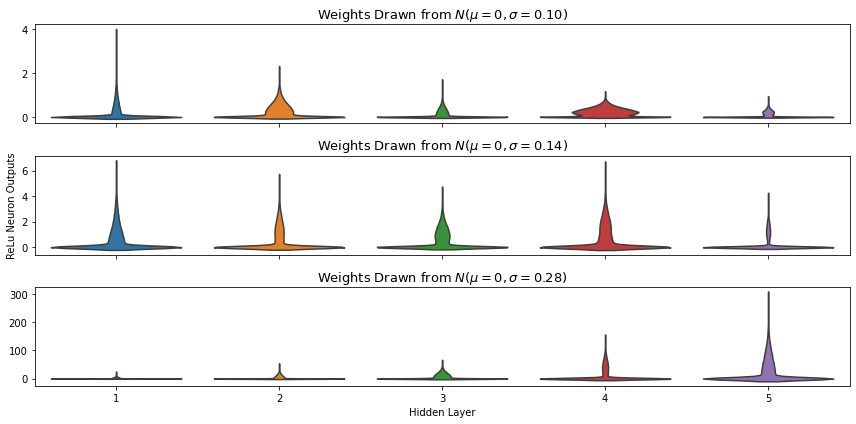

In [ ]:
# initialize weights here using standard normalization 

for stddev in sigmas:
    init = initializers.RandomNormal(mean=0.0, stddev=stddev, seed=seed)
    activation = 'relu'

    model = create_mlp_model(
        n_hidden_layers,
        dim_layer,
        (data_dim,),
        n_classes,
        init,
        'zeros',
        activation
    )
    compile_model(model)
    output_elts = get_activations(model, x_test)
    n_layers = len(model.layers)
    i_output_layer = n_layers - 1

    for i, out in enumerate(output_elts[:-1]):
        if i > 0 and i != i_output_layer:
            for out_i in out.ravel()[::20]:
                rows.append([i, stddev, out_i])

df = pd.DataFrame(rows, columns=['Hidden Layer', 'Standard Deviation', 'Output'])

# Plot previously saved activations from the 5 hidden layers
# using different initialization schemes.
fig = plt.figure(figsize=(12, 6))
axes = grid_axes_it(len(sigmas), 1, fig=fig)
for sig in sigmas:
    ax = next(axes)
    ddf = df[df['Standard Deviation'] == sig]
    sns.violinplot(x='Hidden Layer', y='Output', data=ddf, ax=ax, scale='count', inner=None)

    ax.set_xlabel('')
    ax.set_ylabel('')

    ax.set_title('Weights Drawn from $N(\mu = 0, \sigma = {%.2f})$' % sig, fontsize=13)

    if sig == sigmas[1]:
        ax.set_ylabel("ReLu Neuron Outputs")
    if sig != sigmas[-1]:
        ax.set_xticklabels(())
    else:
        ax.set_xlabel("Hidden Layer")

plt.tight_layout()
plt.show()

Initialize weights using standard normalization.\
 Use activation function tanh :

<ipython-input-5-f5a236607ffa>:39: MatplotlibDeprecationWarning: Passing non-integers as three-element position specification is deprecated since 3.3 and will be removed two minor releases later.
  ax = plt.subplot(n_rows, n_cols, i)
<ipython-input-5-f5a236607ffa>:39: MatplotlibDeprecationWarning: Passing non-integers as three-element position specification is deprecated since 3.3 and will be removed two minor releases later.
  ax = plt.subplot(n_rows, n_cols, i)
<ipython-input-5-f5a236607ffa>:39: MatplotlibDeprecationWarning: Passing non-integers as three-element position specification is deprecated since 3.3 and will be removed two minor releases later.
  ax = plt.subplot(n_rows, n_cols, i)


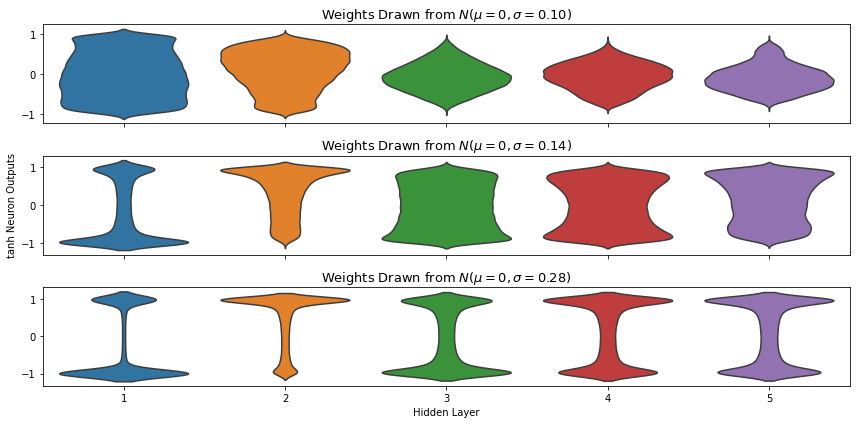

In [ ]:
#activation function  tanh 

# Run the data through a few MLP models and save the activations from
# each layer into a Pandas DataFrame.
rows.clear()


for stddev in sigmas:
    init = initializers.RandomNormal(mean=0.0, stddev=stddev, seed=seed)
    activation = 'tanh'

    model2 = create_mlp_model(
        n_hidden_layers,
        dim_layer,
        (data_dim,),
        n_classes,
        init,
        'zeros',
        activation
    )
    compile_model(model2)
    output_elts = get_activations(model2, x_test)
    n_layers = len(model2.layers)
    i_output_layer = n_layers - 1

    for i, out in enumerate(output_elts[:-1]):
        if i > 0 and i != i_output_layer:
            for out_i in out.ravel()[::20]:
                rows.append([i, stddev, out_i])

df = pd.DataFrame(rows, columns=['Hidden Layer', 'Standard Deviation', 'Output'])

# Plot previously saved activations from the 5 hidden layers
# using different initialization schemes.
fig = plt.figure(figsize=(12, 6))
axes = grid_axes_it(len(sigmas), 1, fig=fig)
for sig in sigmas:
    ax = next(axes)
    ddf = df[df['Standard Deviation'] == sig]
    sns.violinplot(x='Hidden Layer', y='Output', data=ddf, ax=ax, scale='count', inner=None)

    ax.set_xlabel('')
    ax.set_ylabel('')

    ax.set_title('Weights Drawn from $N(\mu = 0, \sigma = {%.2f})$' % sig, fontsize=13)

    if sig == sigmas[1]:
        ax.set_ylabel("tanh Neuron Outputs")
    if sig != sigmas[-1]:
        ax.set_xticklabels(())
    else:
        ax.set_xlabel("Hidden Layer")

plt.tight_layout()
plt.show()

Initialize weights using standard normalization.\
Use activation function sigmoid : 

<ipython-input-5-f5a236607ffa>:39: MatplotlibDeprecationWarning: Passing non-integers as three-element position specification is deprecated since 3.3 and will be removed two minor releases later.
  ax = plt.subplot(n_rows, n_cols, i)
<ipython-input-5-f5a236607ffa>:39: MatplotlibDeprecationWarning: Passing non-integers as three-element position specification is deprecated since 3.3 and will be removed two minor releases later.
  ax = plt.subplot(n_rows, n_cols, i)
<ipython-input-5-f5a236607ffa>:39: MatplotlibDeprecationWarning: Passing non-integers as three-element position specification is deprecated since 3.3 and will be removed two minor releases later.
  ax = plt.subplot(n_rows, n_cols, i)


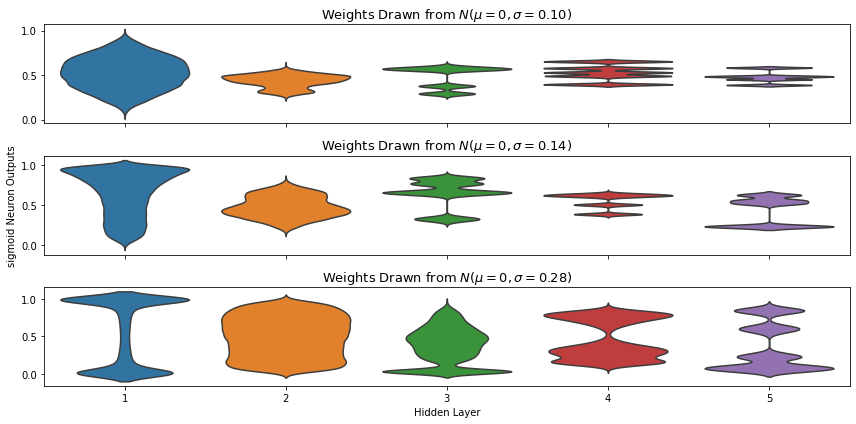

In [ ]:
# activation function sigmoid

rows.clear()

for stddev in sigmas:
    init = initializers.RandomNormal(mean=0.0, stddev=stddev, seed=seed)
    activation = 'sigmoid'

    model3 = create_mlp_model(
        n_hidden_layers,
        dim_layer,
        (data_dim,),
        n_classes,
        init,
        'zeros',
        activation
    )
    compile_model(model3)
    output_elts = get_activations(model3, x_test)
    n_layers = len(model3.layers)
    i_output_layer = n_layers - 1

    for i, out in enumerate(output_elts[:-1]):
        if i > 0 and i != i_output_layer:
            for out_i in out.ravel()[::20]:
                rows.append([i, stddev, out_i])

df = pd.DataFrame(rows, columns=['Hidden Layer', 'Standard Deviation', 'Output'])

# Plot previously saved activations from the 5 hidden layers
# using different initialization schemes.
fig = plt.figure(figsize=(12, 6))
axes = grid_axes_it(len(sigmas), 1, fig=fig)
for sig in sigmas:
    ax = next(axes)
    ddf = df[df['Standard Deviation'] == sig]
    sns.violinplot(x='Hidden Layer', y='Output', data=ddf, ax=ax, scale='count', inner=None)

    ax.set_xlabel('')
    ax.set_ylabel('')

    ax.set_title('Weights Drawn from $N(\mu = 0, \sigma = {%.2f})$' % sig, fontsize=13)

    if sig == sigmas[1]:
        ax.set_ylabel("sigmoid Neuron Outputs")
    if sig != sigmas[-1]:
        ax.set_xticklabels(())
    else:
        ax.set_xlabel("Hidden Layer")

plt.tight_layout()
plt.show()

Report your observations about vanishing gradients.

ReLU activation with 2 different weight initialization methods: 1. Glorot normal(Xavier) 2. He.

<ipython-input-5-f5a236607ffa>:39: MatplotlibDeprecationWarning: Passing non-integers as three-element position specification is deprecated since 3.3 and will be removed two minor releases later.
  ax = plt.subplot(n_rows, n_cols, i)
<ipython-input-5-f5a236607ffa>:39: MatplotlibDeprecationWarning: Passing non-integers as three-element position specification is deprecated since 3.3 and will be removed two minor releases later.
  ax = plt.subplot(n_rows, n_cols, i)
<ipython-input-5-f5a236607ffa>:39: MatplotlibDeprecationWarning: Passing non-integers as three-element position specification is deprecated since 3.3 and will be removed two minor releases later.
  ax = plt.subplot(n_rows, n_cols, i)


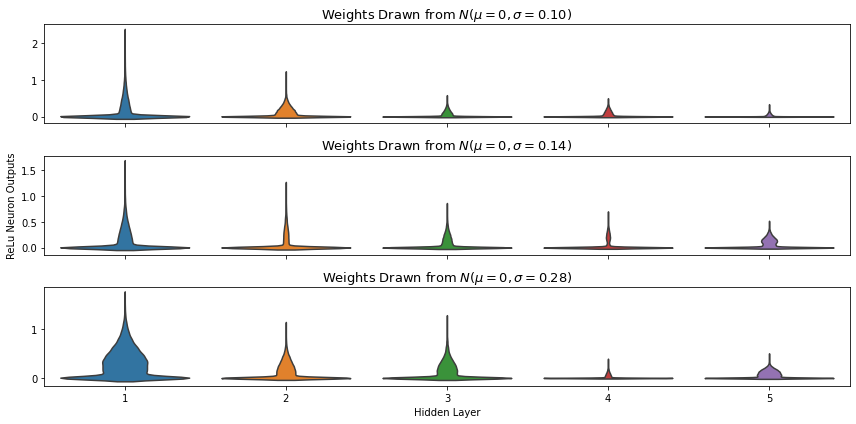

In [ ]:
#ReLU activation with 2 different weight initialization methods: 1. Glorot normal(Xavier) 



rows.clear()

for stddev in sigmas:
    init = initializers.GlorotNormal(seed=seed)
    activation = 'relu'

    model4 = create_mlp_model(
        n_hidden_layers,
        dim_layer,
        (data_dim,),
        n_classes,
        init,
        'zeros',
        activation
    )
    compile_model(model4)
    output_elts = get_activations(model4, x_test)
    n_layers = len(model4.layers)
    i_output_layer = n_layers - 1

    for i, out in enumerate(output_elts[:-1]):
        if i > 0 and i != i_output_layer:
            for out_i in out.ravel()[::20]:
                rows.append([i, stddev, out_i])

df = pd.DataFrame(rows, columns=['Hidden Layer', 'Standard Deviation', 'Output'])

# Plot previously saved activations from the 5 hidden layers
# using different initialization schemes.
fig = plt.figure(figsize=(12, 6))
axes = grid_axes_it(len(sigmas), 1, fig=fig)
for sig in sigmas:
    ax = next(axes)
    ddf = df[df['Standard Deviation'] == sig]
    sns.violinplot(x='Hidden Layer', y='Output', data=ddf, ax=ax, scale='count', inner=None)

    ax.set_xlabel('')
    ax.set_ylabel('')

    ax.set_title('Weights Drawn from $N(\mu = 0, \sigma = {%.2f})$' % sig, fontsize=13)

    if sig == sigmas[1]:
        ax.set_ylabel("ReLu Neuron Outputs")
    if sig != sigmas[-1]:
        ax.set_xticklabels(())
    else:
        ax.set_xlabel("Hidden Layer")

plt.tight_layout()
plt.show()

<ipython-input-5-f5a236607ffa>:39: MatplotlibDeprecationWarning: Passing non-integers as three-element position specification is deprecated since 3.3 and will be removed two minor releases later.
  ax = plt.subplot(n_rows, n_cols, i)
<ipython-input-5-f5a236607ffa>:39: MatplotlibDeprecationWarning: Passing non-integers as three-element position specification is deprecated since 3.3 and will be removed two minor releases later.
  ax = plt.subplot(n_rows, n_cols, i)
<ipython-input-5-f5a236607ffa>:39: MatplotlibDeprecationWarning: Passing non-integers as three-element position specification is deprecated since 3.3 and will be removed two minor releases later.
  ax = plt.subplot(n_rows, n_cols, i)


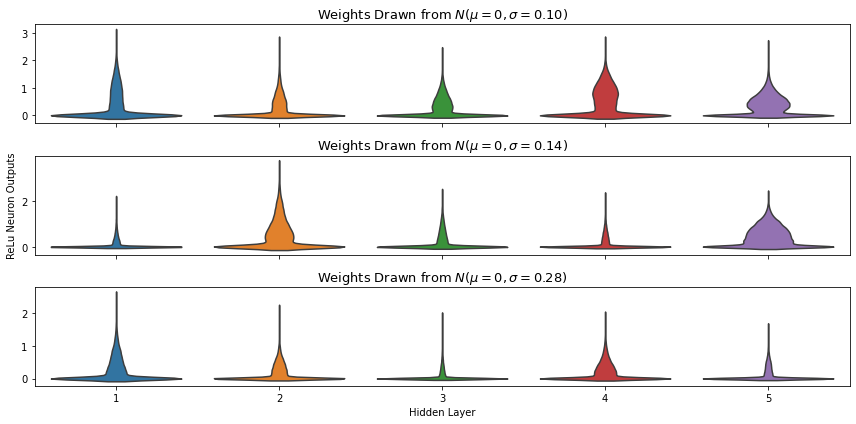

In [ ]:
#ReLU activation with 2 different weight initialization methods: 2 He
rows.clear()

for stddev in sigmas:
    init = initializers.HeNormal(seed=None)
    activation = 'relu'

    model5 = create_mlp_model(
        n_hidden_layers,
        dim_layer,
        (data_dim,),
        n_classes,
        init,
        'zeros',
        activation
    )
    compile_model(model5)
    output_elts = get_activations(model5, x_test)
    n_layers = len(model5.layers)
    i_output_layer = n_layers - 1

    for i, out in enumerate(output_elts[:-1]):
        if i > 0 and i != i_output_layer:
            for out_i in out.ravel()[::20]:
                rows.append([i, stddev, out_i])

df = pd.DataFrame(rows, columns=['Hidden Layer', 'Standard Deviation', 'Output'])

# Plot previously saved activations from the 5 hidden layers
# using different initialization schemes.
fig = plt.figure(figsize=(12, 6))
axes = grid_axes_it(len(sigmas), 1, fig=fig)
for sig in sigmas:
    ax = next(axes)
    ddf = df[df['Standard Deviation'] == sig]
    sns.violinplot(x='Hidden Layer', y='Output', data=ddf, ax=ax, scale='count', inner=None)

    ax.set_xlabel('')
    ax.set_ylabel('')

    ax.set_title('Weights Drawn from $N(\mu = 0, \sigma = {%.2f})$' % sig, fontsize=13)

    if sig == sigmas[1]:
        ax.set_ylabel("ReLu Neuron Outputs")
    if sig != sigmas[-1]:
        ax.set_xticklabels(())
    else:
        ax.set_xlabel("Hidden Layer")

plt.tight_layout()
plt.show()

## 2)
The dying ReLU is a kind of vanishing gradient, which refers to a problem when ReLU neurons become
inactive and only output 0 for any input. In the worst case of dying ReLU, ReLU neurons at a certain
layer are all dead, i.e., the entire network dies and is referred as the dying ReLU neural networks in
Lu et al (reference below). A dying ReLU neural network collapses to a constant function. Show this
phenomenon using any one of the three 1-dimensional functions in page 11 of Lu et al. Use a 10-layer
ReLU network with width 2 (hidden units per layer). Use minibatch of 64 and draw training data
uniformly from $[-\sqrt{7},\sqrt{7}]$ Perform 1000 independent training simulations each with 3,000 training
points. Out of these 1000 simulations, what fraction resulted in neural network collapse. Is your
answer close to over 90% as was reported in Lu et al. ?

In [ ]:
!pip install tqdm
from tqdm import tqdm

def get_model(model_i, n_layers = 10):
  
  # define model
  inputs = layers.Input(shape=(1,), dtype='float32', name=f'input_{model_i}')
  x = layers.Dense(2, activation='relu', name=f'dense_{model_i}_0')(inputs)
  for i in range(1, n_layers):
    x = layers.Dense(2, activation='relu', name=f'dense_{model_i}_{i}')(x)
  outputs = layers.Dense(1, name=f'output_{model_i}')(x)
  model = Model(inputs=inputs, outputs=outputs, name=f"sim_model_{model_i}")

  # compile
  model.compile(loss='mse',
                optimizer='adam')
  
  # return
  return model


# Define simulation variables
n_train = 3000
n_test = 1000
n_sims = 1000
collapsed_counter = 0

for i in tqdm(range(n_sims), total=n_sims):

  # draw data
  X_train = np.random.uniform(low=-np.sqrt(7), high=np.sqrt(7), size=(n_train))
  y_train = np.abs(X_train)

  X_test = np.random.uniform(low=-np.sqrt(7), high=np.sqrt(7), size=(n_test))

  # fetch model
  model = get_model(f'{i}')


  # fit
  _ = model.fit(x=X_train,
                y=y_train,
                epochs=2,
                batch_size=64,
                verbose=0)
  # predict
  y_pred = model.predict(X_test)

  # evaluate collapse
  if np.var(y_pred) <= 10e-4:
    collapsed_counter += 1

Defaulting to user installation because normal site-packages is not writeable
You should consider upgrading via the '/share/apps/python/3.8.6/intel/bin/python -m pip install --upgrade pip' command.


100%|██████████| 1000/1000 [13:09<00:00,  1.27it/s]


In [ ]:
print(f" collapsed: {collapsed_counter*100 / n_sims} %")


 collapsed: 96.5 %


## 3)

Instead of ReLU consider Leaky ReLU activation as defined below: 
Run the 1000 training simulations in part 2 with Leaky ReLU activation and keep everything else the same. Again calculate the fraction of simulations that resulted in neural network collapse. Did Leaky ReLU help in preventing dying neurons? 

In [ ]:
def get_model(model_i, n_layers = 10):
  
  # define model
  inputs = layers.Input(shape=(1,), dtype='float32', name=f'input_{model_i}')
  x = layers.Dense(2, name=f'dense_{model_i}_0')(inputs)
  x = layers.LeakyReLU(alpha=0.01, name=f'leaky_relu_{model_i}_0')(x)
  for i in range(1, n_layers):
    x = layers.Dense(2, name=f'dense_{model_i}_{i}')(x)
    x = layers.LeakyReLU(alpha=0.01, name=f'leaky_relu_{model_i}_{i}')(x)
  outputs = layers.Dense(1, name=f'output_{model_i}')(x)
  model = Model(inputs=inputs, outputs=outputs, name=f"sim_model_{model_i}")

  # compile
  model.compile(loss='mse',
                optimizer='adam')
  
  # return
  return model


# Define simulation variables
n_train = 3000
n_test = 1000
n_sims = 1000
collapsed_counter = 0

for i in tqdm(range(n_sims), total=n_sims):

  # draw data
  X_train = np.random.uniform(low=-np.sqrt(7), high=np.sqrt(7), size=(n_train))
  y_train = np.abs(X_train)

  X_test = np.random.uniform(low=-np.sqrt(7), high=np.sqrt(7), size=(n_test))

  # fetch model
  model = get_model(f'{i}')

  # fit
  _ = model.fit(x=X_train,
                y=y_train,
                epochs=2,
                batch_size=64,
                verbose=0)
  # predict
  y_pred = model.predict(X_test)

  # evaluate collapse
  if np.var(y_pred) <= 10e-4:
    collapsed_counter += 1

100%|██████████| 1000/1000 [13:44<00:00,  1.21it/s]


In [ ]:
print(f" collapsed: {collapsed_counter*100 / n_sims} %")

Leaky ReLU help in preventing dying neurons.

# Problem 2 - Batch Normalization, Dropout, MNIST 20 points

## 1)
Explain the terms co-adaptation and internal covariance-shift. Use examples if needed. You may need to refer to two papers mentioned below to answer this question. 


A:

Co-adaption:\
 Neurons should learn unique features of the data. If nearons behave highly correlated, that is Co-adaption. We can use dropout, or the practice of randomly droping connections in the network during training to fix it.


Internal covariance-shift: \
The fact that the distribution of each layer’s inputs changes during
training, as the parameters of the previous layers change.
This slows down the training by requiring lower learning rates and careful parameter initialization, and makes it notoriously hard to train models with saturating nonlinearities.
Solve: making normalization a part of the model architecture and performing the normalization for each training mini-batch. Batch Normalization allows us to use much higher learning rates and
be less careful about initialization.

## 2)

Batch normalization is traditionally used in hidden layers, for the input layer standard normalization is used. In standard normalization, the mean and standard deviation are calculated using the entire training dataset whereas in batch normalization these statistics are calculated for each mini-batch. Train LeNet-5 with standard normalization of input and batch normalization for hidden layers. What are the learned batch norm parameters for each layer?

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.datasets import mnist
from tensorflow.keras import layers, Model
from tensorflow.keras.utils import to_categorical

# Load dataset as train and test sets
from tensorflow.keras.datasets import mnist
(x_train, y_train), (x_test, y_test) = mnist.load_data()

# Set numeric type to float32 from uint8
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')

# Normalize value to [0, 1]
x_train /= 255
x_test /= 255

x_train = (x_train -0.1307)/0.3081
x_test = (x_test -0.1307)/0.3081

# Transform lables to one-hot encoding
y_train = to_categorical(y_train, 10)
y_test = to_categorical(y_test, 10)

# Reshape the dataset into 4D array
x_train = x_train.reshape(x_train.shape[0], 28, 28, 1)
x_test = x_test.reshape(x_test.shape[0], 28, 28, 1)

print(f"training: {x_train.shape, y_train.shape}")
print(f"testing: {x_test.shape, y_test.shape}")

training: ((60000, 28, 28, 1), (60000, 10))
testing: ((10000, 28, 28, 1), (10000, 10))


In [ ]:
def create_model(model_name):
  """ Function to create the model """

  # Input layer of shape 28x28x1
  inputs = layers.Input(shape=(28, 28, 1), dtype='float32')

  # First convolution block
  x = layers.Conv2D(filters=6,
                    kernel_size=(5, 5),
                    strides=(1, 1),
                    activation='tanh',
                    padding='same')(inputs)
  x = layers.BatchNormalization()(x)
  x = layers.AveragePooling2D(pool_size=(2, 2),
                              strides=(2, 2),
                              padding='valid')(x)

  # Second convolution block
  x = layers.Conv2D(filters=16,
                    kernel_size=(5, 5),
                    strides=(1, 1),
                    activation='tanh',
                    padding='valid')(x)
  x = layers.BatchNormalization()(x)
  x = layers.AveragePooling2D(pool_size=(2, 2),
                              strides=(2, 2),
                              padding='valid')(x)
  
  # Fully connected convolution layer
  x = layers.Conv2D(filters=120,
                    kernel_size=(5, 5),
                    strides=(1, 1),
                    activation='tanh',
                    padding='valid')(x)
  x = layers.BatchNormalization()(x)

  # Flatten and create dense layer
  x = layers.Flatten()(x)
  x = layers.Dense(84, activation='tanh')(x)
  x = layers.BatchNormalization()(x)

  # Output layer with softmax probability activation
  outputs = layers.Dense(10, activation='softmax')(x)

  # Create the model and return
  model = Model(inputs=inputs, outputs=outputs, name=model_name)
  return model

In [ ]:
model = create_model(model_name='lenet5_q2')
model.compile(loss=tf.keras.losses.categorical_crossentropy,
              optimizer='SGD',
              metrics=['accuracy'])
model.summary()

Model: "lenet5_q2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 28, 28, 1)]       0         
                                                                 
 conv2d (Conv2D)             (None, 28, 28, 6)         156       
                                                                 
 batch_normalization (BatchN  (None, 28, 28, 6)        24        
 ormalization)                                                   
                                                                 
 average_pooling2d (AverageP  (None, 14, 14, 6)        0         
 ooling2D)                                                       
                                                                 
 conv2d_1 (Conv2D)           (None, 10, 10, 16)        2416      
                                                                 
 batch_normalization_1 (Batc  (None, 10, 10, 16)       64

In [ ]:
history = model.fit(x=x_train,
                    y=y_train,
                    epochs=10,
                    batch_size=128,
                    validation_data=(x_test, y_test),
                    verbose=1)

Epoch 1/10
469/469 [==============================] - 34s 72ms/step - loss: 0.2668 - accuracy: 0.9276 - val_loss: 0.1261 - val_accuracy: 0.9705
Epoch 2/10
469/469 [==============================] - 33s 71ms/step - loss: 0.1062 - accuracy: 0.9717 - val_loss: 0.0825 - val_accuracy: 0.9782
Epoch 3/10
469/469 [==============================] - 34s 72ms/step - loss: 0.0789 - accuracy: 0.9783 - val_loss: 0.0699 - val_accuracy: 0.9796
Epoch 4/10
469/469 [==============================] - 34s 72ms/step - loss: 0.0667 - accuracy: 0.9812 - val_loss: 0.0550 - val_accuracy: 0.9836
Epoch 5/10
469/469 [==============================] - 33s 71ms/step - loss: 0.0576 - accuracy: 0.9838 - val_loss: 0.0502 - val_accuracy: 0.9855
Epoch 6/10
469/469 [==============================] - 34s 71ms/step - loss: 0.0515 - accuracy: 0.9859 - val_loss: 0.0477 - val_accuracy: 0.9852
Epoch 7/10
469/469 [==============================] - 33s 71ms/step - loss: 0.0471 - accuracy: 0.9875 - val_loss: 0.0454 - val_accuracy:

In [ ]:
batch_norm_l1 = model.get_layer('batch_normalization')
batch_norm_l1.weights

[<tf.Variable 'batch_normalization/gamma:0' shape=(6,) dtype=float32, numpy=
 array([1.0560453, 1.0779752, 1.0046463, 1.015753 , 1.142336 , 1.0550739],
       dtype=float32)>,
 <tf.Variable 'batch_normalization/beta:0' shape=(6,) dtype=float32, numpy=
 array([ 0.03248239, -0.08203508,  0.07423262, -0.05568083,  0.02353233,
         0.02455975], dtype=float32)>,
 <tf.Variable 'batch_normalization/moving_mean:0' shape=(6,) dtype=float32, numpy=
 array([ 0.00118412,  0.10871238, -0.08806054,  0.00484424,  0.05034804,
         0.01275118], dtype=float32)>,
 <tf.Variable 'batch_normalization/moving_variance:0' shape=(6,) dtype=float32, numpy=
 array([0.19484021, 0.30048573, 0.29607564, 0.13561028, 0.2406828 ,
        0.21075614], dtype=float32)>]

In [ ]:
batch_norm_l2 = model.get_layer('batch_normalization_1')
batch_norm_l2.weights

[<tf.Variable 'batch_normalization_1/gamma:0' shape=(16,) dtype=float32, numpy=
 array([1.0154141 , 1.0206652 , 0.9959987 , 1.0255624 , 1.0039716 ,
        0.9835479 , 0.9973856 , 1.0560379 , 1.0133195 , 1.0040122 ,
        1.0128295 , 1.0164115 , 1.0146271 , 0.9932651 , 1.067252  ,
        0.99404204], dtype=float32)>,
 <tf.Variable 'batch_normalization_1/beta:0' shape=(16,) dtype=float32, numpy=
 array([-0.01015509,  0.00361948,  0.00950484,  0.00082473,  0.00168798,
         0.00499556, -0.00138569, -0.0109141 , -0.00313955, -0.00059325,
         0.00654764,  0.00133752,  0.00032018, -0.00699917,  0.00497124,
        -0.00492224], dtype=float32)>,
 <tf.Variable 'batch_normalization_1/moving_mean:0' shape=(16,) dtype=float32, numpy=
 array([-0.23269762,  0.29403713, -0.00625822,  0.04751481,  0.18793678,
        -0.09343266,  0.04269541, -0.1011469 ,  0.07165778, -0.15778133,
         0.19265652, -0.22894229,  0.10259876, -0.02471054,  0.17262481,
         0.13558921], dtype=float32)

In [ ]:
batch_norm_l3 = model.get_layer('batch_normalization_2')
batch_norm_l3.weights

[<tf.Variable 'batch_normalization_2/gamma:0' shape=(120,) dtype=float32, numpy=
 array([1.0019869 , 0.99579227, 0.9915581 , 1.0201868 , 1.0079851 ,
        0.99246895, 0.99359363, 0.99598134, 0.9982053 , 0.99771047,
        0.9987553 , 1.005121  , 0.9935047 , 1.012914  , 1.0033188 ,
        0.9918102 , 0.99559623, 1.0044333 , 1.0003539 , 0.9985013 ,
        0.9960763 , 0.9936786 , 0.9898859 , 0.99715143, 1.0082195 ,
        1.0169008 , 1.0017418 , 1.0107462 , 0.99275196, 0.99430406,
        0.993697  , 1.0073277 , 0.9982665 , 1.0045042 , 1.0109204 ,
        0.994431  , 1.0000876 , 1.0021915 , 1.0038592 , 1.0009176 ,
        0.991624  , 1.012491  , 0.9972867 , 1.0001553 , 0.990791  ,
        1.0059532 , 1.0029049 , 1.0108923 , 1.0035682 , 1.0065519 ,
        0.99569976, 0.99251676, 1.0074351 , 0.99879295, 1.0063634 ,
        1.0038422 , 1.0144497 , 1.0077864 , 1.022158  , 0.9999463 ,
        1.0043062 , 1.018972  , 1.005085  , 0.99334365, 1.0058103 ,
        0.9994266 , 0.9998701 , 0.9

In [ ]:
batch_norm_l4 = model.get_layer('batch_normalization_3')
batch_norm_l4.weights

[<tf.Variable 'batch_normalization_3/gamma:0' shape=(84,) dtype=float32, numpy=
 array([1.0372694, 1.033908 , 1.0211269, 1.0390221, 1.037313 , 1.0161393,
        1.0524049, 1.0356426, 1.0227915, 1.0310552, 1.0071733, 1.0245806,
        1.0282569, 1.021062 , 1.0206637, 1.0105206, 1.0380802, 1.0346464,
        1.047053 , 1.0308285, 1.021063 , 1.0131184, 1.0441701, 1.0302362,
        1.0291893, 1.0376724, 1.068871 , 1.0500433, 1.0539136, 1.0272485,
        1.0340296, 1.053626 , 1.050125 , 1.0161079, 1.0298425, 1.0344325,
        1.0452341, 1.0474734, 1.0198146, 1.0153855, 1.0461751, 1.0281782,
        1.0273741, 1.0148848, 1.0285957, 1.0430534, 1.0497416, 1.0383787,
        1.0401137, 1.0304587, 1.0220108, 1.0285913, 1.0647552, 1.0208987,
        1.0201787, 1.0174698, 1.0476775, 1.0596384, 1.0344617, 1.0468402,
        1.0402596, 1.0017605, 1.0351002, 1.0310895, 1.0413237, 1.0211645,
        1.0407082, 1.0362277, 1.0251546, 1.035659 , 1.041009 , 1.0258497,
        1.0089774, 1.0644033, 1.

standard normalization of input and batch normalization for hidden layers
loss: 0.0381 - accuracy: 0.9892 - val_loss: 0.0452 - val_accuracy: 0.9859

## 3)
Next instead of standard normalization use batch normalization for the input layer also and train the network. Plot the distribution of learned batch norm parameters for each layer (including input) using violin plots. Compare the train/test accuracy and loss for the two cases? Did batch normalization for the input layer improve performance? (4)

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.datasets import mnist
from tensorflow.keras import layers, Model
from tensorflow.keras.utils import to_categorical

# Load dataset as train and test sets
from tensorflow.keras.datasets import mnist
(x_train, y_train), (x_test, y_test) = mnist.load_data()

# Set numeric type to float32 from uint8
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')

# Normalize value to [0, 1]
x_train /= 255
x_test /= 255

# Transform lables to one-hot encoding
y_train = to_categorical(y_train, 10)
y_test = to_categorical(y_test, 10)

# Reshape the dataset into 4D array
x_train = x_train.reshape(x_train.shape[0], 28, 28, 1)
x_test = x_test.reshape(x_test.shape[0], 28, 28, 1)

print(f"training: {x_train.shape, y_train.shape}")
print(f"testing: {x_test.shape, y_test.shape}")

training: ((60000, 28, 28, 1), (60000, 10))
testing: ((10000, 28, 28, 1), (10000, 10))


In [ ]:
def create_model(model_name):
  """ Function to create the model """

  # Input layer of shape 28x28x1
  inputs = layers.Input(shape=(28, 28, 1), dtype='float32')

  #  batch normalization for the input
  x = layers.BatchNormalization()(inputs)

  # First convolution block
  x = layers.Conv2D(filters=6,
                    kernel_size=(5, 5),
                    strides=(1, 1),
                    activation='tanh',
                    padding='same')(x)
  x = layers.BatchNormalization()(x)
  x = layers.AveragePooling2D(pool_size=(2, 2),
                              strides=(2, 2),
                              padding='valid')(x)
  
  # Second convolution block
  x = layers.Conv2D(filters=16,
                    kernel_size=(5, 5),
                    strides=(1, 1),
                    activation='tanh',
                    padding='valid')(x)
  x = layers.BatchNormalization()(x)
  x = layers.AveragePooling2D(pool_size=(2, 2),
                              strides=(2, 2),
                              padding='valid')(x)
  
  # Fully connected convolution layer
  x = layers.Conv2D(filters=120,
                    kernel_size=(5, 5),
                    strides=(1, 1),
                    activation='tanh',
                    padding='valid')(x)
  x = layers.BatchNormalization()(x)

  # Flatten and create dense layer
  x = layers.Flatten()(x)
  x = layers.Dense(84, activation='tanh')(x)
  x = layers.BatchNormalization()(x)
  
  # Output layer with softmax probability activation
  outputs = layers.Dense(10, activation='softmax')(x)

  # Create the model and return
  model = Model(inputs=inputs, outputs=outputs, name=model_name)
  return model


In [ ]:
model = create_model(model_name='lenet5_q3')
model.compile(loss=tf.keras.losses.categorical_crossentropy,
              optimizer='SGD',
              metrics=['accuracy'])


model.summary()

Model: "lenet5_q3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 28, 28, 1)]       0         
                                                                 
 batch_normalization_4 (Batc  (None, 28, 28, 1)        4         
 hNormalization)                                                 
                                                                 
 conv2d_3 (Conv2D)           (None, 28, 28, 6)         156       
                                                                 
 batch_normalization_5 (Batc  (None, 28, 28, 6)        24        
 hNormalization)                                                 
                                                                 
 average_pooling2d_2 (Averag  (None, 14, 14, 6)        0         
 ePooling2D)                                                     
                                                         

In [ ]:
history = model.fit(x=x_train,
                    y=y_train,
                    epochs=10,
                    batch_size=128,
                    validation_data=(x_test, y_test),
                    verbose=1)

Epoch 1/10
469/469 [==============================] - 39s 81ms/step - loss: 0.2563 - accuracy: 0.9294 - val_loss: 0.1295 - val_accuracy: 0.9648
Epoch 2/10
469/469 [==============================] - 38s 80ms/step - loss: 0.1055 - accuracy: 0.9714 - val_loss: 0.0773 - val_accuracy: 0.9784
Epoch 3/10
469/469 [==============================] - 37s 80ms/step - loss: 0.0787 - accuracy: 0.9783 - val_loss: 0.0676 - val_accuracy: 0.9801
Epoch 4/10
469/469 [==============================] - 37s 80ms/step - loss: 0.0650 - accuracy: 0.9819 - val_loss: 0.0536 - val_accuracy: 0.9852
Epoch 5/10
469/469 [==============================] - 38s 80ms/step - loss: 0.0569 - accuracy: 0.9841 - val_loss: 0.0488 - val_accuracy: 0.9850
Epoch 6/10
469/469 [==============================] - 37s 80ms/step - loss: 0.0513 - accuracy: 0.9857 - val_loss: 0.0479 - val_accuracy: 0.9853
Epoch 7/10
469/469 [==============================] - 38s 80ms/step - loss: 0.0468 - accuracy: 0.9867 - val_loss: 0.0432 - val_accuracy:

In [ ]:
# get layers
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

batch_norm_inputs = model.get_layer('batch_normalization_4')
batch_norm_l1 = model.get_layer('batch_normalization_5')
batch_norm_l2 = model.get_layer('batch_normalization_6')
batch_norm_l3 = model.get_layer('batch_normalization_7')
batch_norm_l4 = model.get_layer('batch_normalization_8')


# get weights
inputs_mean = batch_norm_inputs.get_weights()[2]
inputs_var = batch_norm_inputs.get_weights()[3]
l1_mean = batch_norm_l1.get_weights()[2]
l1_var = batch_norm_l1.get_weights()[3]
l2_mean = batch_norm_l2.get_weights()[2]
l2_var = batch_norm_l2.get_weights()[3]
l3_mean = batch_norm_l3.get_weights()[2]
l3_var = batch_norm_l3.get_weights()[3]
l4_mean = batch_norm_l4.get_weights()[2]
l4_var = batch_norm_l4.get_weights()[3]

# create plot structure
df = pd.DataFrame(data={
    'layer': ['input']*2 + ['block1'] * 12 + ['block2'] * 32 + ['block3'] * 240 + ['dense'] * 168,
    'parameter': ['mean', 'var'] + ['mean'] * 6 + ['var'] * 6 + ['mean'] * 16 + ['var'] * 16 + ['mean'] * 120 + ['var'] * 120 + ['mean'] * 84 + ['var'] * 84,
    'value': np.concatenate((inputs_mean, inputs_var, l1_mean, l1_var, l2_mean, l2_var, l3_mean, l3_var, l4_mean, l4_var))})

df.head()

,layer,parameter,value
0,input,mean,0.131065
1,input,var,0.095169
2,block1,mean,-0.088074
3,block1,mean,0.150694
4,block1,mean,-0.016176


Text(0.5, 1.0, 'Batch Normalization Parameters by Layer')

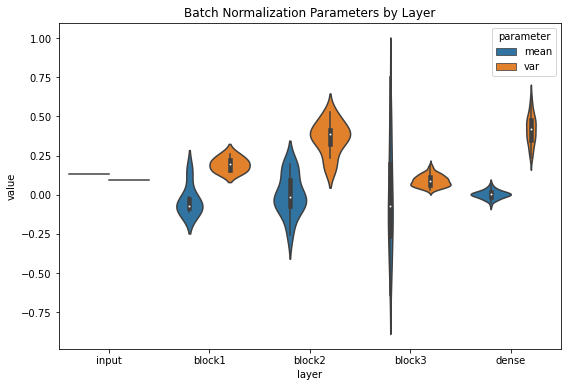

In [ ]:
fig, ax = plt.subplots(figsize=(9, 6))
sns.violinplot(x='layer', y='value', hue='parameter', data=df)
ax.set_title('Batch Normalization Parameters by Layer')

Compare:


Standard  Normaliazation(input) and Batch normalization:\
accuracy :0.9892, val_accuracy 0.9859

Batch normalization(input) and Batch normalization:\
accuracy :0.9898, val_accuracy: 0.9868

## 4)
Train the network without batch normalization but this time use dropout. For hidden layers use a dropout probability of 0.5 and for input, layer take it to be 0.2 Compare test accuracy using dropout to test accuracy obtained using batch normalization in parts 2 and 3.

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.datasets import mnist
from tensorflow.keras import layers, Model
from tensorflow.keras.utils import to_categorical

# Load dataset as train and test sets
from tensorflow.keras.datasets import mnist
(x_train, y_train), (x_test, y_test) = mnist.load_data()

# Set numeric type to float32 from uint8
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')

# Normalize value to [0, 1]
x_train /= 255
x_test /= 255

# Transform lables to one-hot encoding
y_train = to_categorical(y_train, 10)
y_test = to_categorical(y_test, 10)

# Reshape the dataset into 4D array
x_train = x_train.reshape(x_train.shape[0], 28, 28, 1)
x_test = x_test.reshape(x_test.shape[0], 28, 28, 1)

print(f"training: {x_train.shape, y_train.shape}")
print(f"testing: {x_test.shape, y_test.shape}")

training: ((60000, 28, 28, 1), (60000, 10))
testing: ((10000, 28, 28, 1), (10000, 10))


In [ ]:
def create_model(model_name):
  """ Function to create the model """

  # Input layer of shape 28x28x1
  inputs = layers.Input(shape=(28, 28, 1), dtype='float32')

  # Add dropout for the input
  x = layers.Dropout(0.2)(inputs)

  # First convolution block
  x = layers.Conv2D(filters=6,
                    kernel_size=(5, 5),
                    strides=(1, 1),
                    activation='tanh',
                    padding='same')(x)
  x = layers.Dropout(0.5)(x)
  x = layers.AveragePooling2D(pool_size=(2, 2),
                              strides=(2, 2),
                              padding='valid')(x)

  # Second convolution block
  x = layers.Conv2D(filters=16,
                    kernel_size=(5, 5),
                    strides=(1, 1),
                    activation='tanh',
                    padding='valid')(x)
  x = layers.Dropout(0.5)(x)
  x = layers.AveragePooling2D(pool_size=(2, 2),
                              strides=(2, 2),
                              padding='valid')(x)

  # Fully connected convolution layer
  x = layers.Conv2D(filters=120,
                    kernel_size=(5, 5),
                    strides=(1, 1),
                    activation='tanh',
                    padding='valid')(x)
  x = layers.Dropout(0.5)(x)

  # Flatten and create dense layer
  x = layers.Flatten()(x)
  x = layers.Dense(84, activation='tanh')(x)
  x = layers.Dropout(0.5)(x)
  
  # Output layer with softmax probability activation
  outputs = layers.Dense(10, activation='softmax')(x)

  # Create the model and return
  model = Model(inputs=inputs, outputs=outputs, name=model_name)
  return model

In [ ]:
model = create_model(model_name='lenet5_q4')
model.compile(loss=tf.keras.losses.categorical_crossentropy,
              optimizer='SGD',
              metrics=['accuracy'])
model.summary()

Model: "lenet5_q4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 28, 28, 1)]       0         
                                                                 
 dropout (Dropout)           (None, 28, 28, 1)         0         
                                                                 
 conv2d_6 (Conv2D)           (None, 28, 28, 6)         156       
                                                                 
 dropout_1 (Dropout)         (None, 28, 28, 6)         0         
                                                                 
 average_pooling2d_4 (Averag  (None, 14, 14, 6)        0         
 ePooling2D)                                                     
                                                                 
 conv2d_7 (Conv2D)           (None, 10, 10, 16)        2416      
                                                         

In [ ]:
history = model.fit(x=x_train,
                    y=y_train,
                    epochs=10,
                    batch_size=128,
                    validation_data=(x_test, y_test),
                    verbose=1)

Epoch 1/10
469/469 [==============================] - 29s 61ms/step - loss: 1.5724 - accuracy: 0.5042 - val_loss: 0.6605 - val_accuracy: 0.8394
Epoch 2/10
469/469 [==============================] - 29s 62ms/step - loss: 0.7918 - accuracy: 0.7531 - val_loss: 0.4227 - val_accuracy: 0.8852
Epoch 3/10
469/469 [==============================] - 29s 62ms/step - loss: 0.6528 - accuracy: 0.7951 - val_loss: 0.3587 - val_accuracy: 0.8988
Epoch 4/10
469/469 [==============================] - 29s 61ms/step - loss: 0.5928 - accuracy: 0.8150 - val_loss: 0.3256 - val_accuracy: 0.9056
Epoch 5/10
469/469 [==============================] - 29s 61ms/step - loss: 0.5549 - accuracy: 0.8263 - val_loss: 0.3031 - val_accuracy: 0.9097
Epoch 6/10
469/469 [==============================] - 29s 61ms/step - loss: 0.5211 - accuracy: 0.8381 - val_loss: 0.2841 - val_accuracy: 0.9152
Epoch 7/10
469/469 [==============================] - 29s 61ms/step - loss: 0.4994 - accuracy: 0.8465 - val_loss: 0.2663 - val_accuracy:

Compare:



Standard  Normaliazation(input) and Batch normalization:\
accuracy :0.9892, val_accuracy 0.9859

Batch normalization(input) and Batch normalization:\
accuracy :0.9898, val_accuracy: 0.9868

No normalization(input), No Batch normalization, but with Dropout:\
accuracy :0.8662, val_accuracy: 0.9317

## 5)
Now train the network using both batch normalization and dropout. How does the performance (test accuracy) of the network compare with the cases with dropout alone and with batch normalization alone? (4)

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.datasets import mnist
from tensorflow.keras import layers, Model
from tensorflow.keras.utils import to_categorical

# Load dataset as train and test sets
from tensorflow.keras.datasets import mnist
(x_train, y_train), (x_test, y_test) = mnist.load_data()

# Set numeric type to float32 from uint8
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')

# Normalize value to [0, 1]
x_train /= 255
x_test /= 255

# Transform lables to one-hot encoding
y_train = to_categorical(y_train, 10)
y_test = to_categorical(y_test, 10)

# Reshape the dataset into 4D array
x_train = x_train.reshape(x_train.shape[0], 28, 28, 1)
x_test = x_test.reshape(x_test.shape[0], 28, 28, 1)

print(f"training: {x_train.shape, y_train.shape}")
print(f"testing: {x_test.shape, y_test.shape}")

training: ((60000, 28, 28, 1), (60000, 10))
testing: ((10000, 28, 28, 1), (10000, 10))


In [ ]:
def create_model(model_name):
  """ Function to create the model """

  # Input layer of shape 28x28x1
  inputs = layers.Input(shape=(28, 28, 1), dtype='float32')

  # Add dropout and batch normalization for the input
  x = layers.Dropout(0.2)(inputs)
  x = layers.BatchNormalization()(x)

  # First convolution block
  x = layers.Conv2D(filters=6,
                    kernel_size=(5, 5),
                    strides=(1, 1),
                    activation='tanh',
                    padding='same')(x)
  x = layers.Dropout(0.5)(x)
  x = layers.BatchNormalization()(x)
  x = layers.AveragePooling2D(pool_size=(2, 2),
                              strides=(2, 2),
                              padding='valid')(x)

  # Second convolution block
  x = layers.Conv2D(filters=16,
                    kernel_size=(5, 5),
                    strides=(1, 1),
                    activation='tanh',
                    padding='valid')(x)
  x = layers.Dropout(0.5)(x)
  x = layers.BatchNormalization()(x)
  x = layers.AveragePooling2D(pool_size=(2, 2),
                              strides=(2, 2),
                              padding='valid')(x)

  # Fully connected convolution layer
  x = layers.Conv2D(filters=120,
                    kernel_size=(5, 5),
                    strides=(1, 1),
                    activation='tanh',
                    padding='valid')(x)
  x = layers.Dropout(0.5)(x)
  x = layers.BatchNormalization()(x)

  # Flatten and create dense layer
  x = layers.Flatten()(x)
  x = layers.Dense(84, activation='tanh')(x)
  x = layers.Dropout(0.5)(x)
  x = layers.BatchNormalization()(x)

  # Output layer with softmax probability activation
  outputs = layers.Dense(10, activation='softmax')(x)

  # Create the model and return
  model = Model(inputs=inputs, outputs=outputs, name=model_name)
  return model

In [ ]:
model = create_model(model_name='lenet5_q4')
model.compile(loss=tf.keras.losses.categorical_crossentropy,
              optimizer='SGD',
              metrics=['accuracy'])
model.summary()


Model: "lenet5_q4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 28, 28, 1)]       0         
                                                                 
 dropout_5 (Dropout)         (None, 28, 28, 1)         0         
                                                                 
 batch_normalization_9 (Batc  (None, 28, 28, 1)        4         
 hNormalization)                                                 
                                                                 
 conv2d_9 (Conv2D)           (None, 28, 28, 6)         156       
                                                                 
 dropout_6 (Dropout)         (None, 28, 28, 6)         0         
                                                                 
 batch_normalization_10 (Bat  (None, 28, 28, 6)        24        
 chNormalization)                                        

In [ ]:
history = model.fit(x=x_train,
                    y=y_train,
                    epochs=10,
                    batch_size=128,
                    validation_data=(x_test, y_test),
                    verbose=1)

Epoch 1/10
469/469 [==============================] - 42s 89ms/step - loss: 1.0533 - accuracy: 0.6571 - val_loss: 0.3633 - val_accuracy: 0.8956
Epoch 2/10
469/469 [==============================] - 42s 90ms/step - loss: 0.6639 - accuracy: 0.7911 - val_loss: 0.2976 - val_accuracy: 0.9125
Epoch 3/10
469/469 [==============================] - 42s 89ms/step - loss: 0.5703 - accuracy: 0.8213 - val_loss: 0.2587 - val_accuracy: 0.9234
Epoch 4/10
469/469 [==============================] - 42s 89ms/step - loss: 0.5029 - accuracy: 0.8427 - val_loss: 0.2265 - val_accuracy: 0.9310
Epoch 5/10
469/469 [==============================] - 40s 86ms/step - loss: 0.4444 - accuracy: 0.8632 - val_loss: 0.1935 - val_accuracy: 0.9416
Epoch 6/10
469/469 [==============================] - 42s 89ms/step - loss: 0.4017 - accuracy: 0.8774 - val_loss: 0.1595 - val_accuracy: 0.9524
Epoch 7/10
469/469 [==============================] - 42s 90ms/step - loss: 0.3598 - accuracy: 0.8896 - val_loss: 0.1423 - val_accuracy:




 Compare:



Standard  Normaliazation(input) and Batch normalization:\
accuracy :0.9892, val_accuracy 0.9859

Batch normalization(input) and Batch normalization:\
accuracy :0.9898, val_accuracy: 0.9868

No normalization(input), No Batch normalization, but with Dropout:\
accuracy :0.8662, val_accuracy: 0.9317

Batch normalization(input) and Batch normalization and Dropout:\
accuracy :0.9096, val_accuracy: 0.9647

# Problem 3 - Learning Rate, Batch Size, FashionMNIST 15 points


## 1)
Fix batch size to 64 and start with 10 candidate learning rates between 10−9 and 10 and train your model for 5 epochs. Plot the training loss as a function of the learning rate. 

In [ ]:
from tensorflow.keras.datasets import fashion_mnist

(train_images, train_labels), (test_images, test_labels) = fashion_mnist.load_data()

print('\n ----- \n')
print(f"Number of training records: {len(train_images)}")
print(f"Number of test records: {len(test_images)}")
print(f"Total number of records: {len(train_images) + len(test_images)}")


 ----- 

Number of training records: 60000
Number of test records: 10000
Total number of records: 70000


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

train_labels_pd_series = pd.Series(train_labels)
print(f"Number of unique classes: {train_labels_pd_series.nunique()}")
print('Number of images per class in the training dataset:')
train_labels_pd_series.value_counts()


Number of unique classes: 10
Number of images per class in the training dataset:


9    6000
8    6000
7    6000
6    6000
5    6000
4    6000
3    6000
2    6000
1    6000
0    6000
dtype: int64

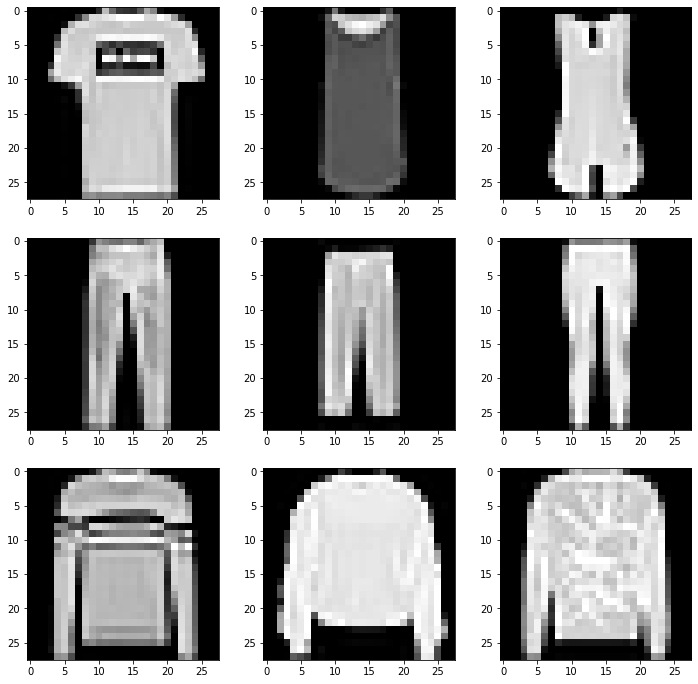

In [ ]:
fig, ax = plt.subplots(3, 3, figsize=(12, 12))
for i in range(3):
  subset_imgs = train_images[train_labels == i, :, :]
  for j in range(3):
    ax[i, j].imshow(subset_imgs[j, :, :], cmap='gray')


train_labels = to_categorical(train_labels)
test_labels = to_categorical(test_labels)

In [ ]:
def create_model(model_name):
  """ Function to create the model """

  # Input layer of shape 28x28x1, making the assumption that
  # the training data has not been normalized
  inputs = layers.Input(shape=(28, 28, 1), dtype='float32')

  # Add batch normalization for the input
  x = layers.BatchNormalization()(inputs)

  # First convolution block
  x = layers.Conv2D(filters=6,
                    kernel_size=(5, 5),
                    strides=(1, 1),
                    activation='tanh',
                    padding='same')(x)
  x = layers.BatchNormalization()(x)
  x = layers.AveragePooling2D(pool_size=(2, 2),
                              strides=(2, 2),
                              padding='valid')(x)
  
  # Second convolution block
  x = layers.Conv2D(filters=16,
                    kernel_size=(5, 5),
                    strides=(1, 1),
                    activation='tanh',
                    padding='valid')(x)
  x = layers.BatchNormalization()(x)
  x = layers.AveragePooling2D(pool_size=(2, 2),
                              strides=(2, 2),
                              padding='valid')(x)
  
  # Fully connected convolution layer
  x = layers.Conv2D(filters=120,
                    kernel_size=(5, 5),
                    strides=(1, 1),
                    activation='tanh',
                    padding='valid')(x)
  x = layers.BatchNormalization()(x)

  # Flatten and create dense layer
  x = layers.Flatten()(x)
  x = layers.Dense(84, activation='tanh')(x)
  x = layers.BatchNormalization()(x)

  # Output layer with softmax probability activation
  outputs = layers.Dense(10, activation='softmax')(x)

  # Create the model and return
  model = Model(inputs=inputs, outputs=outputs, name=model_name)
  return model

In [ ]:

training_loss_log = []
learning_rate_log = []


for i in tqdm(range(-9, 2)):
  lr = 10**i
  model = create_model(f'model_{i}')
  model.compile(loss=tf.keras.losses.categorical_crossentropy,
                optimizer=tf.keras.optimizers.SGD(learning_rate=lr),
                metrics=['accuracy'])
  _ = model.fit(x=train_images,
                y=train_labels,
                batch_size=64,
                epochs=5,
                validation_data = (test_images, test_labels),
                verbose=0)
  training_loss_log.append(model.history.history['loss'][-1])
  learning_rate_log.append(lr)

100%|██████████| 11/11 [33:39<00:00, 183.58s/it]


[Text(0, 0.5, 'Training Loss'),
 Text(0.5, 0, 'Learning Rate'),
 None,
 Text(0.5, 1.0, 'Training Loss vs. Learning Rate')]

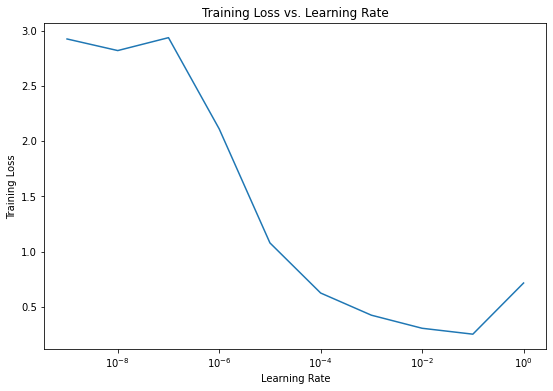

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
fig, ax = plt.subplots(figsize=(9, 6))
sns.lineplot(x=learning_rate_log, y=training_loss_log)
ax.set(ylabel='Training Loss',
       xlabel='Learning Rate',
       xscale='log',
       title='Training Loss vs. Learning Rate')

In [ ]:
lr_max = 10**-9
lr_min = 10**-1

print(f"lr_max={lr_max}, lr_min={lr_min}")

lr_max=1e-09, lr_min=0.1


## 2)
Use the cyclical learning rate policy (with exponential decay) and train your network using batch size 64 and lrmin and lrmax values obtained in part 1. Plot train/validation loss and accuracy curve (similar to Figure 4 in reference). (3)

In [ ]:
from tensorflow.keras.callbacks import *
from tensorflow.keras import backend as K
import numpy as np

class CyclicLR(Callback):
    """This callback implements a cyclical learning rate policy (CLR).
    The method cycles the learning rate between two boundaries with
    some constant frequency, as detailed in this paper (https://arxiv.org/abs/1506.01186).
    The amplitude of the cycle can be scaled on a per-iteration or 
    per-cycle basis.
    This class has three built-in policies, as put forth in the paper.
    "triangular":
        A basic triangular cycle w/ no amplitude scaling.
    "triangular2":
        A basic triangular cycle that scales initial amplitude by half each cycle.
    "exp_range":
        A cycle that scales initial amplitude by gamma**(cycle iterations) at each 
        cycle iteration.
    For more detail, please see paper.
    
    # Example
        ```python
            clr = CyclicLR(base_lr=0.001, max_lr=0.006,
                                step_size=2000., mode='triangular')
            model.fit(X_train, Y_train, callbacks=[clr])
        ```
    
    Class also supports custom scaling functions:
        ```python
            clr_fn = lambda x: 0.5*(1+np.sin(x*np.pi/2.))
            clr = CyclicLR(base_lr=0.001, max_lr=0.006,
                                step_size=2000., scale_fn=clr_fn,
                                scale_mode='cycle')
            model.fit(X_train, Y_train, callbacks=[clr])
        ```    
    # Arguments
        base_lr: initial learning rate which is the
            lower boundary in the cycle.
        max_lr: upper boundary in the cycle. Functionally,
            it defines the cycle amplitude (max_lr - base_lr).
            The lr at any cycle is the sum of base_lr
            and some scaling of the amplitude; therefore 
            max_lr may not actually be reached depending on
            scaling function.
        step_size: number of training iterations per
            half cycle. Authors suggest setting step_size
            2-8 x training iterations in epoch.
        mode: one of {triangular, triangular2, exp_range}.
            Default 'triangular'.
            Values correspond to policies detailed above.
            If scale_fn is not None, this argument is ignored.
        gamma: constant in 'exp_range' scaling function:
            gamma**(cycle iterations)
        scale_fn: Custom scaling policy defined by a single
            argument lambda function, where 
            0 <= scale_fn(x) <= 1 for all x >= 0.
            mode paramater is ignored 
        scale_mode: {'cycle', 'iterations'}.
            Defines whether scale_fn is evaluated on 
            cycle number or cycle iterations (training
            iterations since start of cycle). Default is 'cycle'.
    """

    def __init__(self, base_lr=0.001, max_lr=0.006, step_size=2000., mode='triangular',
                 gamma=1., scale_fn=None, scale_mode='cycle'):
        super(CyclicLR, self).__init__()

        self.base_lr = base_lr
        self.max_lr = max_lr
        self.step_size = step_size
        self.mode = mode
        self.gamma = gamma
        if scale_fn == None:
            if self.mode == 'triangular':
                self.scale_fn = lambda x: 1.
                self.scale_mode = 'cycle'
            elif self.mode == 'triangular2':
                self.scale_fn = lambda x: 1/(2.**(x-1))
                self.scale_mode = 'cycle'
            elif self.mode == 'exp_range':
                self.scale_fn = lambda x: gamma**(x)
                self.scale_mode = 'iterations'
        else:
            self.scale_fn = scale_fn
            self.scale_mode = scale_mode
        self.clr_iterations = 0.
        self.trn_iterations = 0.
        self.history = {}

        self._reset()

    def _reset(self, new_base_lr=None, new_max_lr=None,
               new_step_size=None):
        """Resets cycle iterations.
        Optional boundary/step size adjustment.
        """
        if new_base_lr != None:
            self.base_lr = new_base_lr
        if new_max_lr != None:
            self.max_lr = new_max_lr
        if new_step_size != None:
            self.step_size = new_step_size
        self.clr_iterations = 0.
        
    def clr(self):
        cycle = np.floor(1+self.clr_iterations/(2*self.step_size))
        x = np.abs(self.clr_iterations/self.step_size - 2*cycle + 1)
        if self.scale_mode == 'cycle':
            return self.base_lr + (self.max_lr-self.base_lr)*np.maximum(0, (1-x))*self.scale_fn(cycle)
        else:
            return self.base_lr + (self.max_lr-self.base_lr)*np.maximum(0, (1-x))*self.scale_fn(self.clr_iterations)
        
    def on_train_begin(self, logs={}):
        logs = logs or {}

        if self.clr_iterations == 0:
            K.set_value(self.model.optimizer.lr, self.base_lr)
        else:
            K.set_value(self.model.optimizer.lr, self.clr())        
            
    def on_batch_end(self, epoch, logs=None):
        
        logs = logs or {}
        self.trn_iterations += 1
        self.clr_iterations += 1

        self.history.setdefault('lr', []).append(K.get_value(self.model.optimizer.lr))
        self.history.setdefault('iterations', []).append(self.trn_iterations)

        for k, v in logs.items():
            self.history.setdefault(k, []).append(v)
        
        K.set_value(self.model.optimizer.lr, self.clr())

In [ ]:
clr = CyclicLR(base_lr=lr_min,
               max_lr=lr_max,
               step_size=10**3,
               mode='exp_range',
               gamma=0.99994)

In [ ]:
model = create_model('clr_exp_decay')
model.summary()

Model: "clr_exp_decay"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_18 (InputLayer)       [(None, 28, 28, 1)]       0         
                                                                 
 batch_normalization_79 (Bat  (None, 28, 28, 1)        4         
 chNormalization)                                                
                                                                 
 conv2d_51 (Conv2D)          (None, 28, 28, 6)         156       
                                                                 
 batch_normalization_80 (Bat  (None, 28, 28, 6)        24        
 chNormalization)                                                
                                                                 
 average_pooling2d_34 (Avera  (None, 14, 14, 6)        0         
 gePooling2D)                                                    
                                                     

In [ ]:
model.compile(loss=tf.keras.losses.categorical_crossentropy,
              optimizer='sgd',
              metrics=['accuracy'])

history = model.fit(x=train_images,
                    y=train_labels,
                    batch_size=64,
                    epochs=5,
                    validation_data = (test_images, test_labels),
                    verbose=1,
                    callbacks=[clr])

Epoch 1/5
938/938 [==============================] - 39s 41ms/step - loss: 0.4513 - accuracy: 0.8360 - val_loss: 0.3545 - val_accuracy: 0.8704
Epoch 2/5
938/938 [==============================] - 38s 41ms/step - loss: 0.3390 - accuracy: 0.8769 - val_loss: 0.4327 - val_accuracy: 0.8388
Epoch 3/5
938/938 [==============================] - 38s 41ms/step - loss: 0.3026 - accuracy: 0.8888 - val_loss: 0.2927 - val_accuracy: 0.8930
Epoch 4/5
938/938 [==============================] - 38s 40ms/step - loss: 0.2600 - accuracy: 0.9038 - val_loss: 0.3527 - val_accuracy: 0.8742
Epoch 5/5
938/938 [==============================] - 38s 41ms/step - loss: 0.2633 - accuracy: 0.9026 - val_loss: 0.2947 - val_accuracy: 0.8928


[Text(0, 0.5, 'Metric'),
 Text(0.5, 0, 'Epoch'),
 Text(0.5, 1.0, 'CyclicLR w/Exp Decay Metrics')]

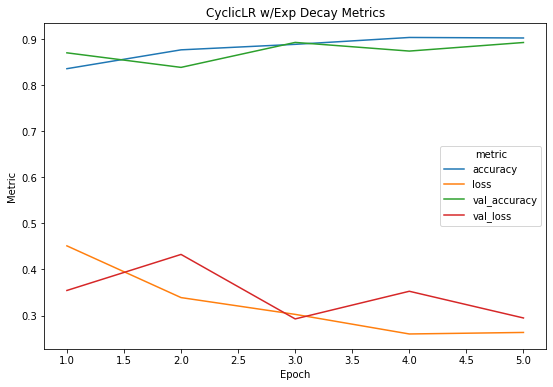

In [ ]:
df_metrics = pd.DataFrame(data={
    'epoch': [i for i in range(1, 6)] * 4,
    'metric': ['accuracy'] * 5 + ['loss'] * 5 + ['val_accuracy'] * 5 + ['val_loss'] * 5,
    'value': history.history['accuracy'] + history.history['loss'] + history.history['val_accuracy'] + history.history['val_loss']
})

df_metrics.head()
fig, ax = plt.subplots(figsize=(9, 6))
sns.lineplot(x='epoch', y='value', hue='metric', data=df_metrics)
ax.set(ylabel='Metric',
       xlabel='Epoch',
       title='CyclicLR w/Exp Decay Metrics')

## 3)
We want to test if increasing batch size for a fixed learning rate has the same effect as decreasing learning rate for fixed batch size. Fix learning rate to lrmax and train your network starting with batch size 32 and incrementally going up to 16384 (in increments of a factor of 2; like 32, 64...). You can choose a step size (in terms of the number of iterations) to increment the batch size. If your GPU cannot handle large batch sizes, you need to employ an effective batch size approach as discussed in Lecture 3 to simulate large batches. Plot the training loss. Is the generalization of your final model similar or different from than cyclical learning rate policy? (10)

In [ ]:
!pip install tqdm
from tqdm import tqdm

Defaulting to user installation because normal site-packages is not writeable
You should consider upgrading via the '/share/apps/python/3.8.6/intel/bin/python -m pip install --upgrade pip' command.


In [ ]:
training_loss_log = []
batch_size_log = []

for i in tqdm(range(5, 15)):
  bs = 2**i
  model = create_model(f'model_bs_{i}')
  model.compile(loss=tf.keras.losses.categorical_crossentropy,
                optimizer=tf.keras.optimizers.SGD(learning_rate=lr_max),
                metrics=['accuracy'])
  _ = model.fit(x=train_images,
                y=train_labels,
                batch_size=bs,
                epochs=5,
                validation_data = (test_images, test_labels),
                verbose=0)
  training_loss_log.append(model.history.history['loss'][-1])
  batch_size_log.append(bs)

100%|██████████| 10/10 [35:44<00:00, 214.49s/it]


[Text(0, 0.5, 'Training Loss'),
 Text(0.5, 0, 'Batch Size'),
 Text(0.5, 1.0, 'Training Loss vs. Batch Size')]

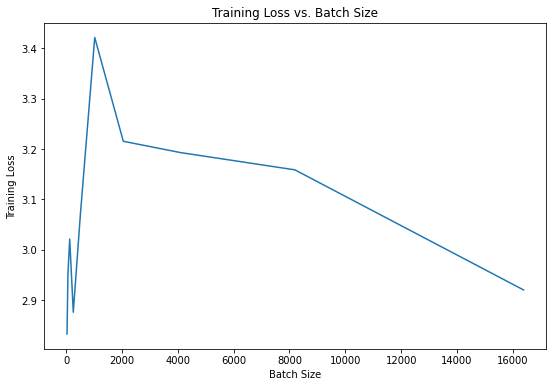

In [ ]:
fig, ax = plt.subplots(figsize=(9, 6))
sns.lineplot(x=batch_size_log, y=training_loss_log)
ax.set(ylabel='Training Loss',
       xlabel='Batch Size',
       title='Training Loss vs. Batch Size')

# Problem 4 - Adaptive Learning Rate Methods, CIFAR-10 20 points

## 1)
Write the weight update equations for the five adaptive learning rate methods. Explain each term clearly. What are the hyperparameters in each policy? Explain how AdaDelta and Adam are different from RMSProp.



**A**:

 $\eta$ represent the learning rate for all five learning rate methods.

##### -- **AdaGrad** --

$g_{t,i}$ represent the partial derivative of model parameter $\theta_i$ at time step $t$:

$$ g_{t,i} = \nabla_{\theta}J(\theta_{t,i}) $$

Where $J$ represents the objective function we are trying to optimize over.

The Stochastic Gradient Descent for each model parameter $\theta_i$ at each time step $t$ now becomes:

$$ \theta_{t+1,i} = \theta_{t,i} - \eta g_{t,i} $$

Each update, AdaGrad changes the learning rate $\eta$ for each model parameter based on the past gradients for each model parameter. Let $G_t$ be an $dxd$ matrix where each diagonal element $i$, $i$ is the sum of the squares of the gradients w.r.t. $\theta_i$ up to time step $t$

$$ \theta_{t+1, i} = \theta_{t,i} - \frac{\eta}{\sqrt{G_{t,ii} + \epsilon}} g_{t,i} $$

Here, $\epsilon$ is a smoothing parameter so that we don't incur division by zero errors.

Because $G_t$ contains the sum of squares of the gradients w.r.t $\theta$ on the diagonal, the implementation can be vectorized by taking the matrix vector product $\odot$ between $G_t$ and $g_t$:

$$ \theta_{t+1} = \theta_t - \frac{\eta}{\sqrt{G_t+ \epsilon}} \odot g_t $$

##### -- **RMSProp** --

RMSProp is identical to the first update vector of AdaDelta below (using $\gamma$ = 0.9):

$$ E[g^2]_t = 0.9 E[g^2]_{t-1} + 0.1g_t^2 $$

The parameter update formula is thus:

$$ \theta_{t+1} = \theta_t - \frac{\eta}{\sqrt{E[g_t]^2 + \epsilon}} g_t $$ 

##### -- **RMSProp + Nesterov** --

Adam is essentially RMSProp with momentum. RMSProp + Nesterov momentum (also known as Nadam) takes it a step further to use Nesterov which is proven to be better than standard momentum.

The momentum update rule is:

$$ g_t = \nabla _{\theta_t}J(\theta_t) $$

$$ m_t = \gamma m_{t-1} + \eta g_t $$

$$ \theta_{t+1} = \theta_t - m_t $$

In the above series of formulas, $J$ is the objective funtion, $\gamma$ is the momentum decay term, and $\eta$ is the step size. We can combine the second into the third:

$$ \theta_{t+1} = \theta_t - ( \gamma m_{t-1} + \eta g_t ) $$

This shows that momentum involves taking a step in the direction of the previous momentum vector as well as a step in the direction of the current gradient.

RMSProp + Nesterov allows us to take a more accurate step in the gradient direction by updating the parameters with the momentum step before computing the gradient. We thus only need to modify the gradient $g_t$ to arrive at RMSProp + Nesterov:

$$ g_t = \nabla _{\theta_t}J(\theta_t - \gamma m_{t-1}) $$

$$ m_t = \gamma m_{t-1} + \eta g_t $$

$$ \theta_{t+1} = \theta_t - m_t $$

One note from above is that we are actually apply momentum twice; once in the gradient calculation as well as in the parameter update. One way to correct for this is to apply the momentum directly to the current parameter updates as opposed to the gradient.

$$ g_t = \nabla _{\theta_t}J(\theta_t) $$

$$ m_t = \gamma m_{t-1} + \eta g_t $$

$$ \theta_{t+1} = \theta_t - ( \gamma m_{t-1} + \eta g_t ) $$

In order to add Nesterov momentum, we can thus similarly replace the previous momentum vector with the current momentum vector.

Using the Adam update formulas from below:

$$ m_t = \beta_1 m_{t-1} + (1-\beta_1)g_t $$

$$ \hat{m}_t = \frac{m_t}{1 - \beta_1^t} $$

$$ \theta_{t+1} = \theta_t - \frac{\eta}{\sqrt{\hat{v}_t} + \epsilon} \hat{m}_t $$

Plugging $m_t$ and $\hat{m}_t$ into the parameter update equation yields:

$$ \theta_{t+1} = \theta_t - \frac{\eta}{\sqrt{\hat{v}_t} + \epsilon} (\frac{\beta_1m_{t-1}}{1-\beta_1^t} + \frac{(1-\beta_1)g_t}{1-\beta_1^t}) $$

We are still using the previous momentum vector, so to add Nesterov momentum, we simply use the current momentum vector. Simplifying and replacing $\frac{\beta_1m_{t-1}}{1-\beta_1^t} = \hat{m}_{t-1}$, we get the final RMSProp + Nesterov update formula:

$$ \theta_{t+1} = \theta_t - \frac{\eta}{\sqrt{\hat{v}_t} + \epsilon} (\beta_1\hat{m}_{t} + \frac{(1-\beta_1)g_t}{1-\beta_1^t}) $$

##### -- **AdaDelta** --

AdaDelta is similar to AdaGrad but slightly different in the sense that it restricts the accumulation of all past gradients to a fixed window $w$.

Instead of inefficiently storing $w$ previous squared gradients, the sum of gradients is recursively defined as a decaying average of all past squared gradients.  The running average $E[g^2]_t$ at time $t$ thus depends only on the previous average and current gradient.

$$ E[g^2]_t = \gamma E[g^2]_{t-1} + (1 - \gamma)g_t^2 $$

This is the running average ($E$) of the squared gradients ($g^2$) at time ($t$) with momentum ($\gamma$).

We can simplify the paramater update.

$$\triangle \theta_t = -\eta \cdot g_t$$
$$\theta_{t+1} = \theta_t + \triangle \theta_t $$

Using the AdaGrad derived parameter update formula from above and replacing $G_t$ with $E[g^2]_t$.

$$ \Delta\theta_t = - \frac{\eta}{\sqrt{ E[g^2]_t+ \epsilon}} g_t $$

The denominator of the above formula is simply the Root Mean Squared error and can be rewritten.

$$ \Delta\theta_t = - \frac{\eta}{RMS[g]_t} g_t $$

The units from the above formula do not match. To fix this, we define another exponentially decaying average not of the gradients but of the parameter updates.

$$ E[\Delta\theta^2]_t = \gamma E[\Delta\theta^2]_{t-1} + (1 - \gamma)\Delta\theta^2 $$

The root mean square error of the parameter updates is thus:

$$ RMS[\Delta\theta]_t = \sqrt{E[\Delta\theta^2]_t + \epsilon} $$

Because the above is unknown, we can approximate it with the RMS of parameter updates until the previous time step. Replacing learning rate $\eta$ with $RMS[\Delta\theta]_{t-1}$ yields:

$$ \Delta\theta_t = - \frac{RMS[\Delta\theta]_{t-1}}{RMS[g]_t} g_t $$

$$ \theta_{t+1} = \theta_t + \Delta \theta_t $$

##### -- **Adam** --

Adam also computes adaptive learning rates per model parameters. Adam stores the exponentially decaying average of past squared gradients $v_t$ similarly to AdaDelta and RMSProp, but also stores the past exponentially decaying gradients $m_t$, similar to momentum.  We compute the decaying averages of past and past squared gradients $m_t% and $v_t$ respectively as follows: 

$$ m_t = \beta_1 m_{t-1} + (1-\beta_1)g_t $$
$$ v_t = \beta_2 v_{t-1} + (1-\beta_2)g_t^2 $$

$m_t$ and $v_t$ are estimates of the first and second moment (mean and variance) of the gradients, respectively.

When $m_t$ and $v_t$ are initialized to vectors of 0s, they bias towards 0, especially in the initial time steps. In order to account for this, we take bias-corrected estimates as follows:

$$ \hat{m}_t = \frac{m_t}{1 - \beta_1^t} $$

$$ \hat{v}_t = \frac{v_t}{1 - \beta_2^t} $$

Using these in the same parameter update formula as AdaDelta and RMSProp yields the final Adam update rule:

$$ \theta_{t+1} = \theta_t - \frac{\eta}{\sqrt{\hat{v}_t} + \epsilon} \hat{m}_t $$

AdaDelta and Adam are different from RMSProp in the sense that both of them use momentum whereas RMSProp does not.

## 2)

Train the neural network using all the five methods with L2-regularization for 200 epochs each and plot the training loss vs the number of epochs. Which method performs best (lowest training loss)?




In [3]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.datasets import cifar10
from tensorflow.keras import layers, Model
from tensorflow.keras.utils import to_categorical

tf.__version__


'2.8.0'

In [4]:
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

# Set numeric type to float32 from uint8
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')

# Normalize value to [0, 1]
x_train /= 255
x_test /= 255

# flatten x matrices
x_train = x_train.reshape(x_train.shape[0], -1)
x_test = x_test.reshape(x_test.shape[0], -1)

# expand y targets
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)

print(x_train.shape, y_train.shape)
print(x_test.shape, y_test.shape)

170508288/170498071 [==============================] - 2s 0us/step
(50000, 3072) (50000, 10)
(10000, 3072) (10000, 10)


In [5]:
def create_model(model_name, optimizer, dropout=False):
  """ Return network for training. """
  
  # define input
  inputs = layers.Input(shape=(3072,), dtype='float32', name=f'input_{model_name}')

  # add fully connected with dropout if needed
  if dropout:
    x = layers.Dropout(0.2, name=f'input_dropout_{model_name}')(inputs)
    for i in range(2):
      x = layers.Dense(1000,
                       activation='relu',
                       kernel_regularizer='l2',
                       bias_regularizer='l2',
                       name=f'dense_{i}_{model_name}')(x)
      x = layers.Dropout(0.5, name=f'dropout_{i}_{model_name}')(x)
  else:
      x = layers.Dense(1000,
                       activation='relu',
                       kernel_regularizer='l2',
                       bias_regularizer='l2',
                       name=f'dense_0_{model_name}')(inputs)
      x = layers.Dense(1000,
                       activation='relu',
                       kernel_regularizer='l2',
                       bias_regularizer='l2',
                       name=f'dense_1_{model_name}')(x)
  
  outputs = layers.Dense(10,
                         activation='softmax',
                         name=f'output_{model_name}')(x)
  
  model = Model(inputs=inputs, outputs=outputs, name=model_name)

  # compile
  if optimizer == 'adagrad':
    opt = keras.optimizers.Adagrad(name=f'adagrad_{model_name}')
  elif optimizer == 'rmsprop':
    opt = keras.optimizers.RMSprop(name=f'rmsprop_{model_name}')
  elif optimizer == 'nadam':
    opt = keras.optimizers.Nadam(name=f'nadam_{model_name}')
  elif optimizer == 'adadelta':
    opt = keras.optimizers.Adadelta(name=f'adadelta_{model_name}')
  elif optimizer == 'adam':
    opt = keras.optimizers.Adam(name=f'adam_{model_name}')
  else:
    raise NotImplementedError
  
  model.compile(loss='categorical_crossentropy',
                optimizer=opt,
                metrics=['acc'])
  
  # return
  return model

In [6]:
from time import time

training adagrad without dropout...
training rmsprop without dropout...
training nadam without dropout...
training adadelta without dropout...
training adam without dropout...
adagrad
	Minimum Training Loss: 1.5984597206115723
	Final Training Loss: 1.5984597206115723
rmsprop
	Minimum Training Loss: 1.952917218208313
	Final Training Loss: 1.957898736000061
nadam
	Minimum Training Loss: 1.809017300605774
	Final Training Loss: 1.837280511856079
adadelta
	Minimum Training Loss: 4.717377662658691
	Final Training Loss: 4.717377662658691
adam
	Minimum Training Loss: 1.8328505754470825
	Final Training Loss: 1.8562946319580078


Text(0.5, 1.0, 'Training Loss Per Optimizer (No Dropout)')

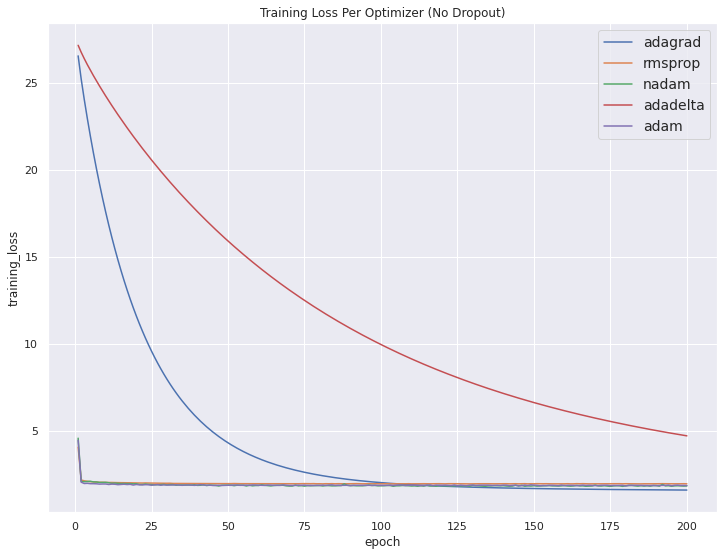

In [7]:
OPTIMIZERS = ['adagrad', 'rmsprop', 'nadam', 'adadelta', 'adam']
METRICS = dict()
for opt in OPTIMIZERS:
  print(f'training {opt} without dropout...')
  model = create_model(model_name = opt, optimizer=opt, dropout=False)
  t1 = time()
  history = model.fit(x=x_train,
                      y=y_train,
                      epochs=200,
                      batch_size=128,
                      verbose=0)
  t2 = time()
  METRICS[opt] = {
      'history': history,
      'training_time': t2 - t1,
      'test_acc': model.evaluate(x_test, y_test, return_dict=True, verbose=0)['acc']
  }

  import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
sns.set_theme(style="darkgrid")


DATA = {
    'optimizer': [],
    'epoch': [],
    'training_loss': []
}

for opt in METRICS.keys():
  opt_hist = METRICS[opt]['history']
  opt_loss = opt_hist.history['loss']
  DATA['optimizer'] += [opt] * 200
  DATA['epoch'] += [i+1 for i in range(200)]
  DATA['training_loss'] += opt_loss
  print(f'{opt}\n\tMinimum Training Loss: {min(opt_loss)}\n\tFinal Training Loss: {opt_loss[-1]}')

df = pd.DataFrame(data=DATA)

fig, ax = plt.subplots(figsize=(12, 9))
sns.lineplot(x='epoch', y='training_loss', hue='optimizer', data=df)
plt.legend(fontsize=14)
plt.title('Training Loss Per Optimizer (No Dropout)')

## 3)

Add dropout (probability 0.2 for input layer and 0.5 for hidden layers) and train the neural network again using all the five methods for 200 epochs. Compare the training loss with that in part 2. Which method performs the best? For the five methods, compare their training time (to finish 200 epochs with dropout) to the training time in part 2 (to finish 200 epochs without dropout). (5)

training adagrad with dropout...
training rmsprop with dropout...
training nadam with dropout...
training adadelta with dropout...
training adam with dropout...
adagrad
	Minimum Training Loss: 1.7180548906326294
	Final Training Loss: 1.7199056148529053
rmsprop
	Minimum Training Loss: 2.247166633605957
	Final Training Loss: 2.2615363597869873
nadam
	Minimum Training Loss: 2.207120180130005
	Final Training Loss: 2.287813425064087
adadelta
	Minimum Training Loss: 5.576839923858643
	Final Training Loss: 5.576839923858643
adam
	Minimum Training Loss: 2.305711030960083
	Final Training Loss: 2.3791139125823975


Text(0.5, 1.0, 'Training Loss Per Optimizer (With Dropout)')

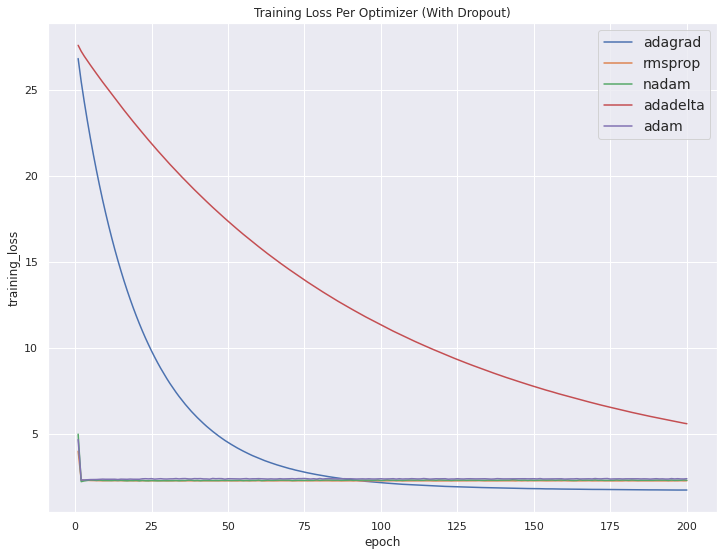

In [9]:
OPTIMIZERS = ['adagrad', 'rmsprop', 'nadam', 'adadelta', 'adam']
METRICS_DROPOUT = dict()
for opt in OPTIMIZERS:
  print(f'training {opt} with dropout...')
  model = create_model(model_name = opt, optimizer=opt, dropout=True)
  t1 = time()
  history = model.fit(x=x_train,
                      y=y_train,
                      epochs=200,
                      batch_size=128,
                      verbose=0)
  t2 = time()
  METRICS_DROPOUT[opt] = {
      'history': history,
      'training_time': t2 - t1,
      'test_acc': model.evaluate(x_test, y_test, return_dict=True, verbose=0)['acc']
  }

  DATA = {
    'optimizer': [],
    'epoch': [],
    'training_loss': []
}

for opt in METRICS_DROPOUT.keys():
  opt_hist = METRICS_DROPOUT[opt]['history']
  opt_loss = opt_hist.history['loss']
  DATA['optimizer'] += [opt] * 200
  DATA['epoch'] += [i+1 for i in range(200)]
  DATA['training_loss'] += opt_loss
  print(f'{opt}\n\tMinimum Training Loss: {min(opt_loss)}\n\tFinal Training Loss: {opt_loss[-1]}')

df_dropout = pd.DataFrame(data=DATA)

fig, ax = plt.subplots(figsize=(12, 9))
sns.lineplot(x='epoch', y='training_loss', hue='optimizer', data=df_dropout)
plt.legend(fontsize=14)
plt.title('Training Loss Per Optimizer (With Dropout)')

In [10]:
for opt in OPTIMIZERS:
  print(f'--- {opt} ---')

  non_dropout_opt_metrics = METRICS[opt]
  dropout_opt_metrics = METRICS_DROPOUT[opt]
  print('\tTraining Time:')
  print(f"\t\tNon Dropout: {non_dropout_opt_metrics['training_time']}")
  print(f"\t\tDropout: {dropout_opt_metrics['training_time']}")
  print('\tTraining Loss:')
  print(f"\t\tNon Dropout: {min(non_dropout_opt_metrics['history'].history['loss'])}")
  print(f"\t\tDropout: {min(dropout_opt_metrics['history'].history['loss'])}")

--- adagrad ---
	Training Time:
		Non Dropout: 499.5125606060028
		Dropout: 562.9347956180573
	Training Loss:
		Non Dropout: 1.5984597206115723
		Dropout: 1.7180548906326294
--- rmsprop ---
	Training Time:
		Non Dropout: 630.0826940536499
		Dropout: 683.6910231113434
	Training Loss:
		Non Dropout: 1.952917218208313
		Dropout: 2.247166633605957
--- nadam ---
	Training Time:
		Non Dropout: 863.3716242313385
		Dropout: 923.207436800003
	Training Loss:
		Non Dropout: 1.809017300605774
		Dropout: 2.207120180130005
--- adadelta ---
	Training Time:
		Non Dropout: 562.6506960391998
		Dropout: 562.7839548587799
	Training Loss:
		Non Dropout: 4.717377662658691
		Dropout: 5.576839923858643
--- adam ---
	Training Time:
		Non Dropout: 502.70108246803284
		Dropout: 516.3755345344543
	Training Loss:
		Non Dropout: 1.8328505754470825
		Dropout: 2.305711030960083


In [11]:
for opt in OPTIMIZERS:
  print(f'--- {opt} ---')

  non_dropout_opt_metrics = METRICS[opt]
  dropout_opt_metrics = METRICS_DROPOUT[opt]
  print('\tTest Accuracy:')
  print(f"\t\tNon Dropout: {non_dropout_opt_metrics['test_acc']}")
  print(f"\t\tDropout: {dropout_opt_metrics['test_acc']}")

--- adagrad ---
	Test Accuracy:
		Non Dropout: 0.5092999935150146
		Dropout: 0.4781000018119812
--- rmsprop ---
	Test Accuracy:
		Non Dropout: 0.36320000886917114
		Dropout: 0.2190999984741211
--- nadam ---
	Test Accuracy:
		Non Dropout: 0.43700000643730164
		Dropout: 0.27619999647140503
--- adadelta ---
	Test Accuracy:
		Non Dropout: 0.4456999897956848
		Dropout: 0.4043999910354614
--- adam ---
	Test Accuracy:
		Non Dropout: 0.4431999921798706
		Dropout: 0.2401999980211258


## 4)

Compare test accuracy of the trained model for all the five methods from part 2 and part 3. Note that to calculate test accuracy of the model trained using dropout you need to appropriately scale the weights (by the dropout probability).


In [12]:
for opt in OPTIMIZERS:
  print(f'--- {opt} ---')

  non_dropout_opt_metrics = METRICS[opt]
  dropout_opt_metrics = METRICS_DROPOUT[opt]
  print('\tTest Accuracy:')
  print(f"\t\tNon Dropout: {non_dropout_opt_metrics['test_acc']}")
  print(f"\t\tDropout: {dropout_opt_metrics['test_acc']}")

--- adagrad ---
	Test Accuracy:
		Non Dropout: 0.5092999935150146
		Dropout: 0.4781000018119812
--- rmsprop ---
	Test Accuracy:
		Non Dropout: 0.36320000886917114
		Dropout: 0.2190999984741211
--- nadam ---
	Test Accuracy:
		Non Dropout: 0.43700000643730164
		Dropout: 0.27619999647140503
--- adadelta ---
	Test Accuracy:
		Non Dropout: 0.4456999897956848
		Dropout: 0.4043999910354614
--- adam ---
	Test Accuracy:
		Non Dropout: 0.4431999921798706
		Dropout: 0.2401999980211258


# Problem 5 - Convolutional Neural Networks Architectures 25 points

## 1)

Calculate the number of parameters in Alexnet. You will have to show calculations for each layer and then sum it to obtain the total number of parameters in Alexnet. When calculating you will need to account for all the filters (size, strides, padding) at each layer. Look at Sec. 3.5 and Figure 2 in Alexnet paper (see reference). Points will only be given when explicit calculations are shown for each layer. (4)

Below is a table depicting the inputs, outputs, and number of parameters for each layer in AlexNet (note, bias is included):

| Layer | Input Size | Layer Description | Number of Parameters | Output Size |
|---|---|---|---|---|
| Input | 3 x 27 x 27 | | | 3 x 27 x 27 |
| Convolution | 3 x 27 x 27 | 11 x 11 filter, 96 filters, stride 4 | (11 x 11 x 3 + 1) x 96 = 34944 | 96 x 55 x 55 |
| Max Pooling | 96 x 55 x 55 | 3 x 3 filter, stride 2 | | 96 x 27 x 27 |
| Normalizing | 96 x 27 x 27 | | | 96 x 27 x 27 |
| Convolution | 96 x 27 x 27 | 5 x 5 filter, 256 filters, stride 1, padding 2 | (5 x 5 x 96 + 1) x 256 = 614656 | 256 x 27 x 27 |
| Max Pooling | 256 x 27 x 27 | 3 x 3 filter, stride 2 | | 256 x 13 x 13 |
| Normalizing | 256 x 13 x 13 | | | 256 x 13 x 13 |
| Convolution | 256 x 13 x 13 | 3 x 3 filter, 384 filters, stride 1, padding 1 | (3 x 3 x 256 + 1) x 384 = 885120 | 384 x 13 x 13 |
| Convolution | 384 x 13 x 13 | 3 x 3 filters, 384 filters, stride 1, padding 1 | (3 x 3 x 384 + 1) x 384 = 1327488 | 384 x 13 x 13 |
| Convolution | 384 x 13 x 13 | 3 x 3 filters, 256 filters, stride 1, padding 1 | (3 x 3 x 384 + 1) x 256 = 884992 | 256 x 13 x 13 |
| Max Pooling | 256 x 13 x 13 | 3 x 3 filter, stride 2 | | 256 x 6 x 6 |
| Dense | 256 x 6 x 6 | 4096 units | 256 x 6 x 6 x 4096 = 37748736 | 4096 |
| Dense | 4096 | 4096 units | 4096 x 4096 = 16777216 | 4096 |
| Dense | 4096 | 1000 units | 4096 x 1000 = 4096000 | 1000 |

Summing the Number of Parameters columns shows that AlexNet in total contains 62369152 learning parameters.

## 2)

VGG (Simonyan et al.) has an extremely homogeneous architecture that only performs 3x3 convolutions with stride 1 and pad 1 and 2x2 max pooling with stride 2 (and no padding) from the beginning to the end. However VGGNet is very expensive to evaluate and uses a lot more memory and parameters. Refer to VGG19 architecture on page 3 in Table 1 of the paper by Simonyan et al. You need to complete Table 1 below for calculating activation units and parameters at each layer in VGG19 (without counting biases). Its been partially filled for you. (6)

| Layer | Number of Activations (Memory) | Parameters (Compute) |
|---|---|---|
| Input | 224 x 224 x 3 = 150K | 0 |
| CONV3-64 | 224 x 224 x 64 = 3.2M | (3 x 3 x 3) x 64 = 1728 |
| CONV3-64 | 224 x 224 x 64 = 3.2M | (3 x 3 x 64) x 64 = 36864 |
| POOL2 | 112 x 112 x 64 = 800K | 0 |
| CONV3-128 | 112 x 112 x 128 = 1.6M | (3 x 3 x 64) x 128 = 73728 |
| CONV3-128 | 112 x 112 x 128 = 1.6M | (3 x 3 x 128) x 128 = 147456 |
| POOL2 | 56 x 56 x 128 = 400K | 0 |
| CONV3-256 | 56 x 56 x 256 = 800K | (3 x 3 x 128) x 256 = 294912 |
| CONV3-256 | 56 x 56 x 256 = 800K | (3 x 3 x 256) x 256 = 589824 |
| CONV3-256 | 56 x 56 x 256 = 800K | (3 x 3 x 256) x 256 = 589824 |
| CONV3-256 | 56 x 56 x 256 = 800K | (3 x 3 x 256) x 256 = 589824 |
| POOL2 | 28 x 28 x 256 = 200K | 0 |
| CONV3-512 | 28 x 28 x 512 = 400K | (3 x 3 x 256) x 512 = 1179648 |
| CONV3-512 | 28 x 28 x 512 = 400K | (3 x 3 x 512) x 512 = 2359296 |
| CONV3-512 | 28 x 28 x 512 = 400K | (3 x 3 x 512) x 512 = 2359296 |
| CONV3-512 | 28 x 28 x 512 = 400K | (3 x 3 x 512) x 512 = 2359296 |
| POOL2 | 14 x 14 x 512 = 100K | 0 |
| CONV3-512 | 14 x 14 x 512 = 100K | (3 x 3 x 512) x 512 = 2359296 |
| CONV3-512 | 14 x 14 x 512 = 100K | (3 x 3 x 512) x 512 = 2359296 |
| CONV3-512 | 14 x 14 x 512 = 100K | (3 x 3 x 512) x 512 = 2359296 |
| CONV3-512 | 14 x 14 x 512 = 100K | (3 x 3 x 512) x 512 = 2359296 |
| POOL2 | 7 x 7 x 512 = 25K | 0 |
| FC | 4096 | (7 x 7 x 512) x 4096 = 102760448 |
| FC | 4096 | 4096 x 4096 = 16777216 |
| FC | 1000 | 4096 x 1000 = 4096000 |
| TOTAL | 16M | 143652544 |

## 3)


VGG architectures have smaller filters but deeper networks compared to Alexnet (3x3 compared to 11x11 or 5x5). Show that a stack of N convolution layers each of filter size F × F has the same receptive field as one convolution layer with filter of size (NF − N + 1) × (NF − N + 1). Use this to calculate the receptive field of 3 filters of size 5x5. (3)

**A**:\
An convolution activation field is $L - F + 1$ where $L$ and $F$ are the length of the input image (assuming square) and convolution filter size (assuming square as well) respectively.

The first of $N$ successive stacks of convolutions on an $F x F$ filter results in an output activation map of: 
$$ L - F + 1 $$

Repeating the convolution on this output yields:

$$ (L - F + 1) - F + 1 = L - 2F + 2 $$

Repeating a third time results in:

$$ (L - 2F + 2) - F + 1 = L - 3F + 3 $$

It is easy to see that stacking $N$ convolution filters successively results in an output activation size $ L - NF + N $.

one convolution of filter size $ (NF - N + 1) $ yields:

$$ L - (NF - N + 1) + 1 = L - NF + N $$

This is the same as above .

Using the formula to calculate the output of 3 successive 5 x 5 filters results in an output size of:

$$ L - 3 x 5 + 3 = L - 12 $$

Using CIFAR-10 32x32 images as an example, the output size of 3 5x5 filters on this dataset would be a 20 x 20 feature map.

## 4)

The original Googlenet paper (Szegedy et al.) proposes two architectures for Inception module, shown in Figure 2 on page 5 of the paper, referred to as naive and dimensionality reduction respectively.
###(a) 
What is the general idea behind designing an inception module (parallel convolutional filters of different sizes with a pooling followed by concatenation) in a convolutional neural network ? (2)

The general idea behind an inception module is to preserve local feature correlations of various sizes while also maintaining the sparsity that leads to reasonable training time and model size. Inception modules can be thought of as a dimensionality reduction technique within network while still allowing for state-of-the-art model performance.

###(b) 
Assuming the input to inception module (referred to as ”previous layer” in Figure 2 of the pa- per) has size 32x32x256, calculate the output size after filter concatenation for the naive and dimensionality reduction inception architectures with number of filters given in Figure 1. (3)

For the naive version and the dimensionality reduction version, we zero-pad each convolution so that they can be concatenated together.

For the naive Inception module, the output of the three convolution branches and one max pooling branch are $32x32x128$, $32x32x192$, $32x32x96$, and $32x32x256$ respectively. This results in a dimension of $32x32x672$ coming out of the concatenation layer.

As for the dimensionality reduction module, the output of the three convolution branches and one max pooling branch are $32x32x128$, $32x32x192$, $32x32x96$, and $32x32x64$ respectively. This results in a dimension of $32x32x480$ coming out of the concatenation layer.

###(c) 
Next calculate the total number of convolutional operations for each of the two inception archi- tecture again assuming the input to the module has dimensions 32x32x256 and number of filters given in Figure 1. (3)

For the Naive architecture:

```
# First Convolution Block
(32 x 32) x (1 x 1 x 256) x 128 = 33,554,432 Multiplications

# Second Convolution Block
(32 x 32) x (3 x 3 x 256) x 192 = 452,984,832 Multiplications

# Third Convolution Block
(32 x 32) x (5 x 5 x 256) x 96 = 629,145,600 Multiplications

TOTAL = 33,554,432 + 452,984,832 + 629,145,600 = 1.11B Multiplications
```

For the Dimensionality Reduction architecture

```
# First Convolution Block
(32 x 32) x (1 x 1 x 256) x 128 = 33,554,432 Multiplications

# Second Convolution Block
(32 x 32) x (1 x 1 x 256) x 128 = 33,554,432 Multiplications
(32 x 32) x (3 x 3 x 128) x 192 = 226,492,416 Multiplications

# Third Convolution Block
(32 x 32) x (1 x 1 x 256) x 32 = 8,388,608 Multiplications
(32 x 32) x (5 x 5 x 32) x 96 = 78,643,200 Multiplications

# Max Pooling Block
(32 x 32) x (1 x 1 x 256) x 64 = 16,777,216 Multiplications

TOTAL = 33,554,432 + (33,554,432 + 226,492,416) + (8,388,608 + 78,643,200) + 16,777,216 = 397M Multiplications
```


###(d) 
Based on the calculations in part (c) explain the problem with naive architecture and how dimen- sionality reduction architecture helps (Hint: compare computational complexity). How much is the computational saving ? (2+2)

The naive architecture still generates a lot of parameters despite the attempt to go "wide" instead of "deep". The dimensionality reduction architecture helps in this by first reducing the dimension with $n$ smaller $1x1$ filters where $n$ is less than the input dimension of the Inception module.

Based on the calculations from part c, the dimensionality reduction architecture reduces the number of multiplications needed in the naive architecture by a factor of roughly 3.